In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras as k
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization # type: ignore
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.models import load_model # type: ignore
from tensorflow.keras.utils import plot_model # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import gc
import warnings
warnings.filterwarnings('ignore')

2023-04-23 22:58:54.265099: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-23 22:58:54.674605: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-23 22:58:54.675341: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 22:58:55.899820: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train_df = pd.read_pickle(
    '/workspace/Ashrae-Energy-Prediction-III/src/data/train_df.pkl')

In [3]:
print('Shape of the training dataset: ', train_df.shape)

Shape of the training dataset:  (19456584, 92)


In [4]:
train_df.head()

,index,building_id,meter,timestamp,meter_reading,date,meter_reading_log1p,hour,day,weekend,...,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72,air_smooth,dew_smooth,air_diff,dew_diff,air_diff2,dew_diff2,square_feet_np_log1p
0,103,105,0,2016-01-01,23.303600,2016-01-01,3.191406,0,1,4,...,3.099609,3.099609,NaN,3.917969,2.333984,-0.681641,-0.188110,0.127197,0.023788,10.835938
1,1101977,454,0,2016-01-21,32.980000,2016-01-21,3.525391,0,21,3,...,11.296875,0.000000,2.542969,-3.435547,-4.257812,-0.127319,0.039124,0.056000,-0.492432,9.718750
2,1101976,453,0,2016-01-21,22.750000,2016-01-21,3.167969,0,21,3,...,11.296875,0.000000,2.542969,-3.435547,-4.257812,-0.127319,0.039124,0.056000,-0.492432,10.125000
3,1101975,452,0,2016-01-21,81.940002,2016-01-21,4.417969,0,21,3,...,11.296875,0.000000,2.542969,-3.435547,-4.257812,-0.127319,0.039124,0.056000,-0.492432,11.953125
4,1101974,451,0,2016-01-21,12.460000,2016-01-21,2.599609,0,21,3,...,11.296875,0.000000,2.542969,-3.435547,-4.257812,-0.127319,0.039124,0.056000,-0.492432,8.523438


In [5]:
train_df = train_df.drop(['meter_reading'], axis=1)

In [6]:
X_train, X_val = train_test_split(
    train_df, test_size=0.2, random_state=42, shuffle=True, stratify=train_df['groupNum_train'])
y_train = X_train['meter_reading_log1p'] # type: ignore
y_val = X_val['meter_reading_log1p'] # type: ignore 
X_train = X_train.drop(['meter_reading_log1p'], axis=1) # type: ignore
X_val = X_val.drop(['meter_reading_log1p'], axis=1) # type: ignore

In [7]:
print('Unique values of the groupNum_train in X_train: ', np.sort(
    X_train['groupNum_train'].unique()))
print('Unique values of the groupNum_train in X_val: ', np.sort(
    X_val['groupNum_train'].unique()))

Unique values of the groupNum_train in X_train:  [  0   1  10  13  20  21  23  30  40  50  60  61  62  70  71  72  73  80
  90  91  92 100 101 103 110 111 113 120 130 131 132 140 141 142 143 150
 151 152 153]
Unique values of the groupNum_train in X_val:  [  0   1  10  13  20  21  23  30  40  50  60  61  62  70  71  72  73  80
  90  91  92 100 101 103 110 111 113 120 130 131 132 140 141 142 143 150
 151 152 153]


In [8]:
print('Shape of the training dataset: ', X_train.shape)
print('Shape of the validation dataset: ', X_val.shape)
print('Shape of the training labels: ', y_train.shape)
print('Shape of the validation labels: ', y_val.shape)

del train_df
gc.collect()

Shape of the training dataset:  (15565267, 90)
Shape of the validation dataset:  (3891317, 90)
Shape of the training labels:  (15565267,)
Shape of the validation labels:  (3891317,)


4

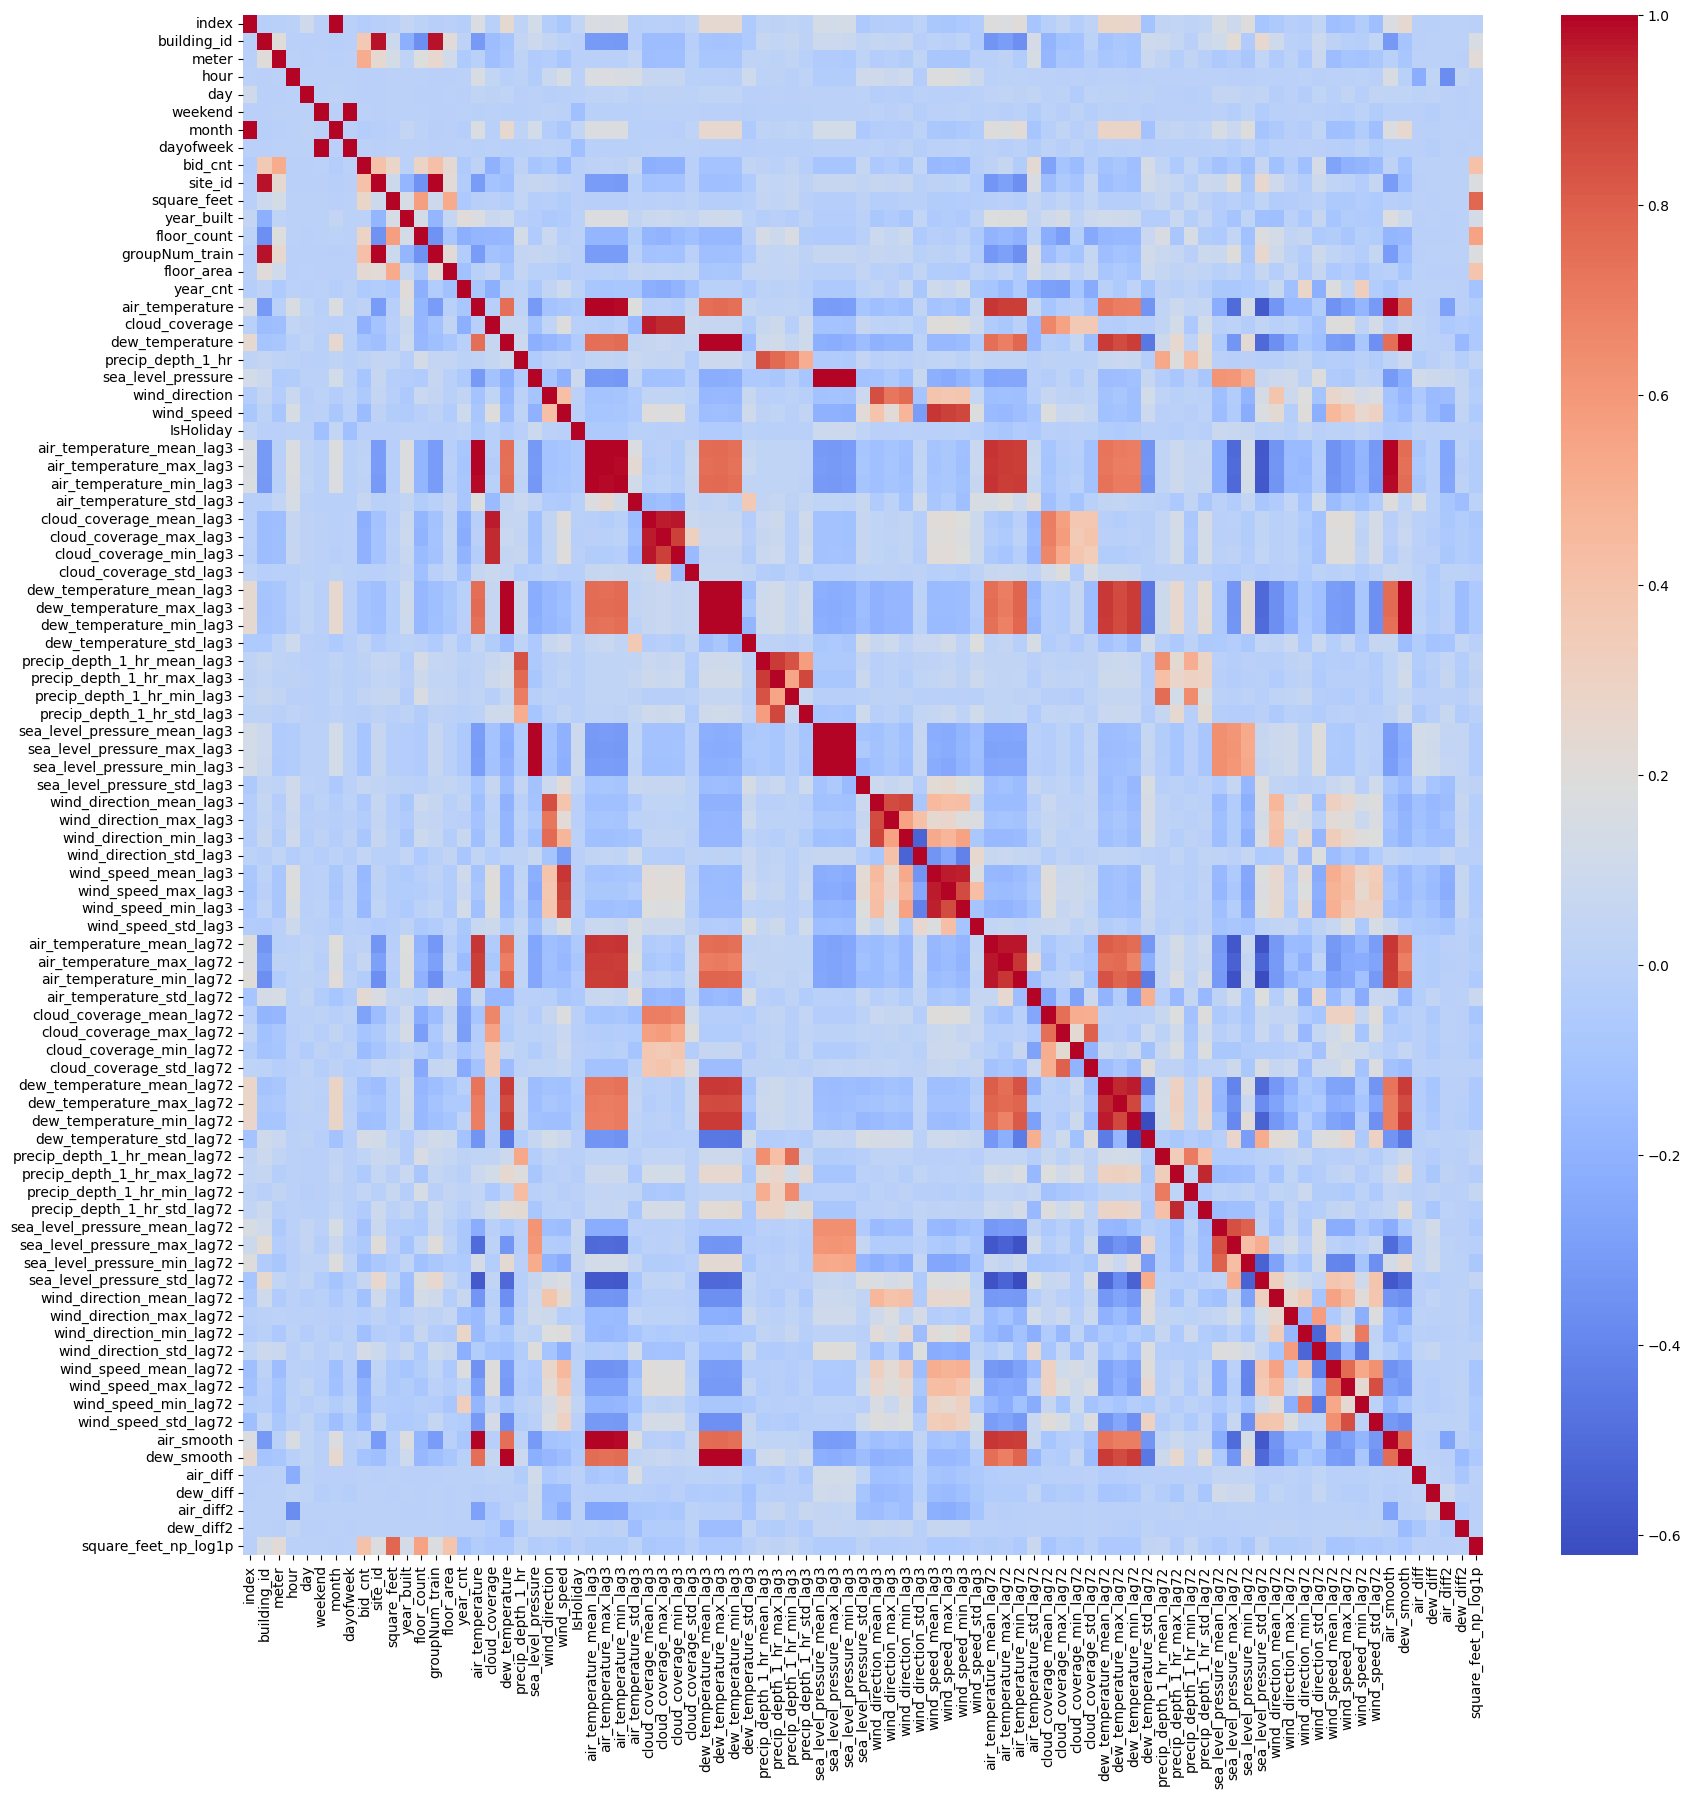

19919

In [9]:
X_train_subset = X_train.sample(frac=0.1, random_state=42)
corr = X_train_subset.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=False, fmt='.2f', cmap='coolwarm')
plt.show()

del X_train_subset
gc.collect()

In [10]:
print("Feature Selection...")

category_cols = ['building_id', 'site_id', 'primary_use',
                 'IsHoliday']  # , 'groupNum_train']  # , 'meter'
feature_cols = ['square_feet_np_log1p', 'year_built'] + [
    'hour', 'weekend',
    #    'day', # 'month' ,
    #    'dayofweek',
    #    'building_median'
    #    'square_feet'
] + [
    'air_temperature', 'cloud_coverage',
    'dew_temperature', 'precip_depth_1_hr',
    'sea_level_pressure',
    # 'wind_direction', 'wind_speed',
    'air_temperature_mean_lag72',
    'air_temperature_max_lag72', 'air_temperature_min_lag72',
    'air_temperature_std_lag72', 'cloud_coverage_mean_lag72',
    'dew_temperature_mean_lag72', 'precip_depth_1_hr_mean_lag72',
    'sea_level_pressure_mean_lag72',
    # 'wind_direction_mean_lag72',
    'wind_speed_mean_lag72',
    'air_temperature_mean_lag3',
    'air_temperature_max_lag3',
    'air_temperature_min_lag3', 'cloud_coverage_mean_lag3',
    'dew_temperature_mean_lag3',
    'precip_depth_1_hr_mean_lag3',
    'sea_level_pressure_mean_lag3',
    #    'wind_direction_mean_lag3', 'wind_speed_mean_lag3',
    #    'floor_area',
    'year_cnt', 'bid_cnt',
    'dew_smooth', 'air_smooth',
    'dew_diff', 'air_diff',
    'dew_diff2', 'air_diff2'
]

Feature Selection...


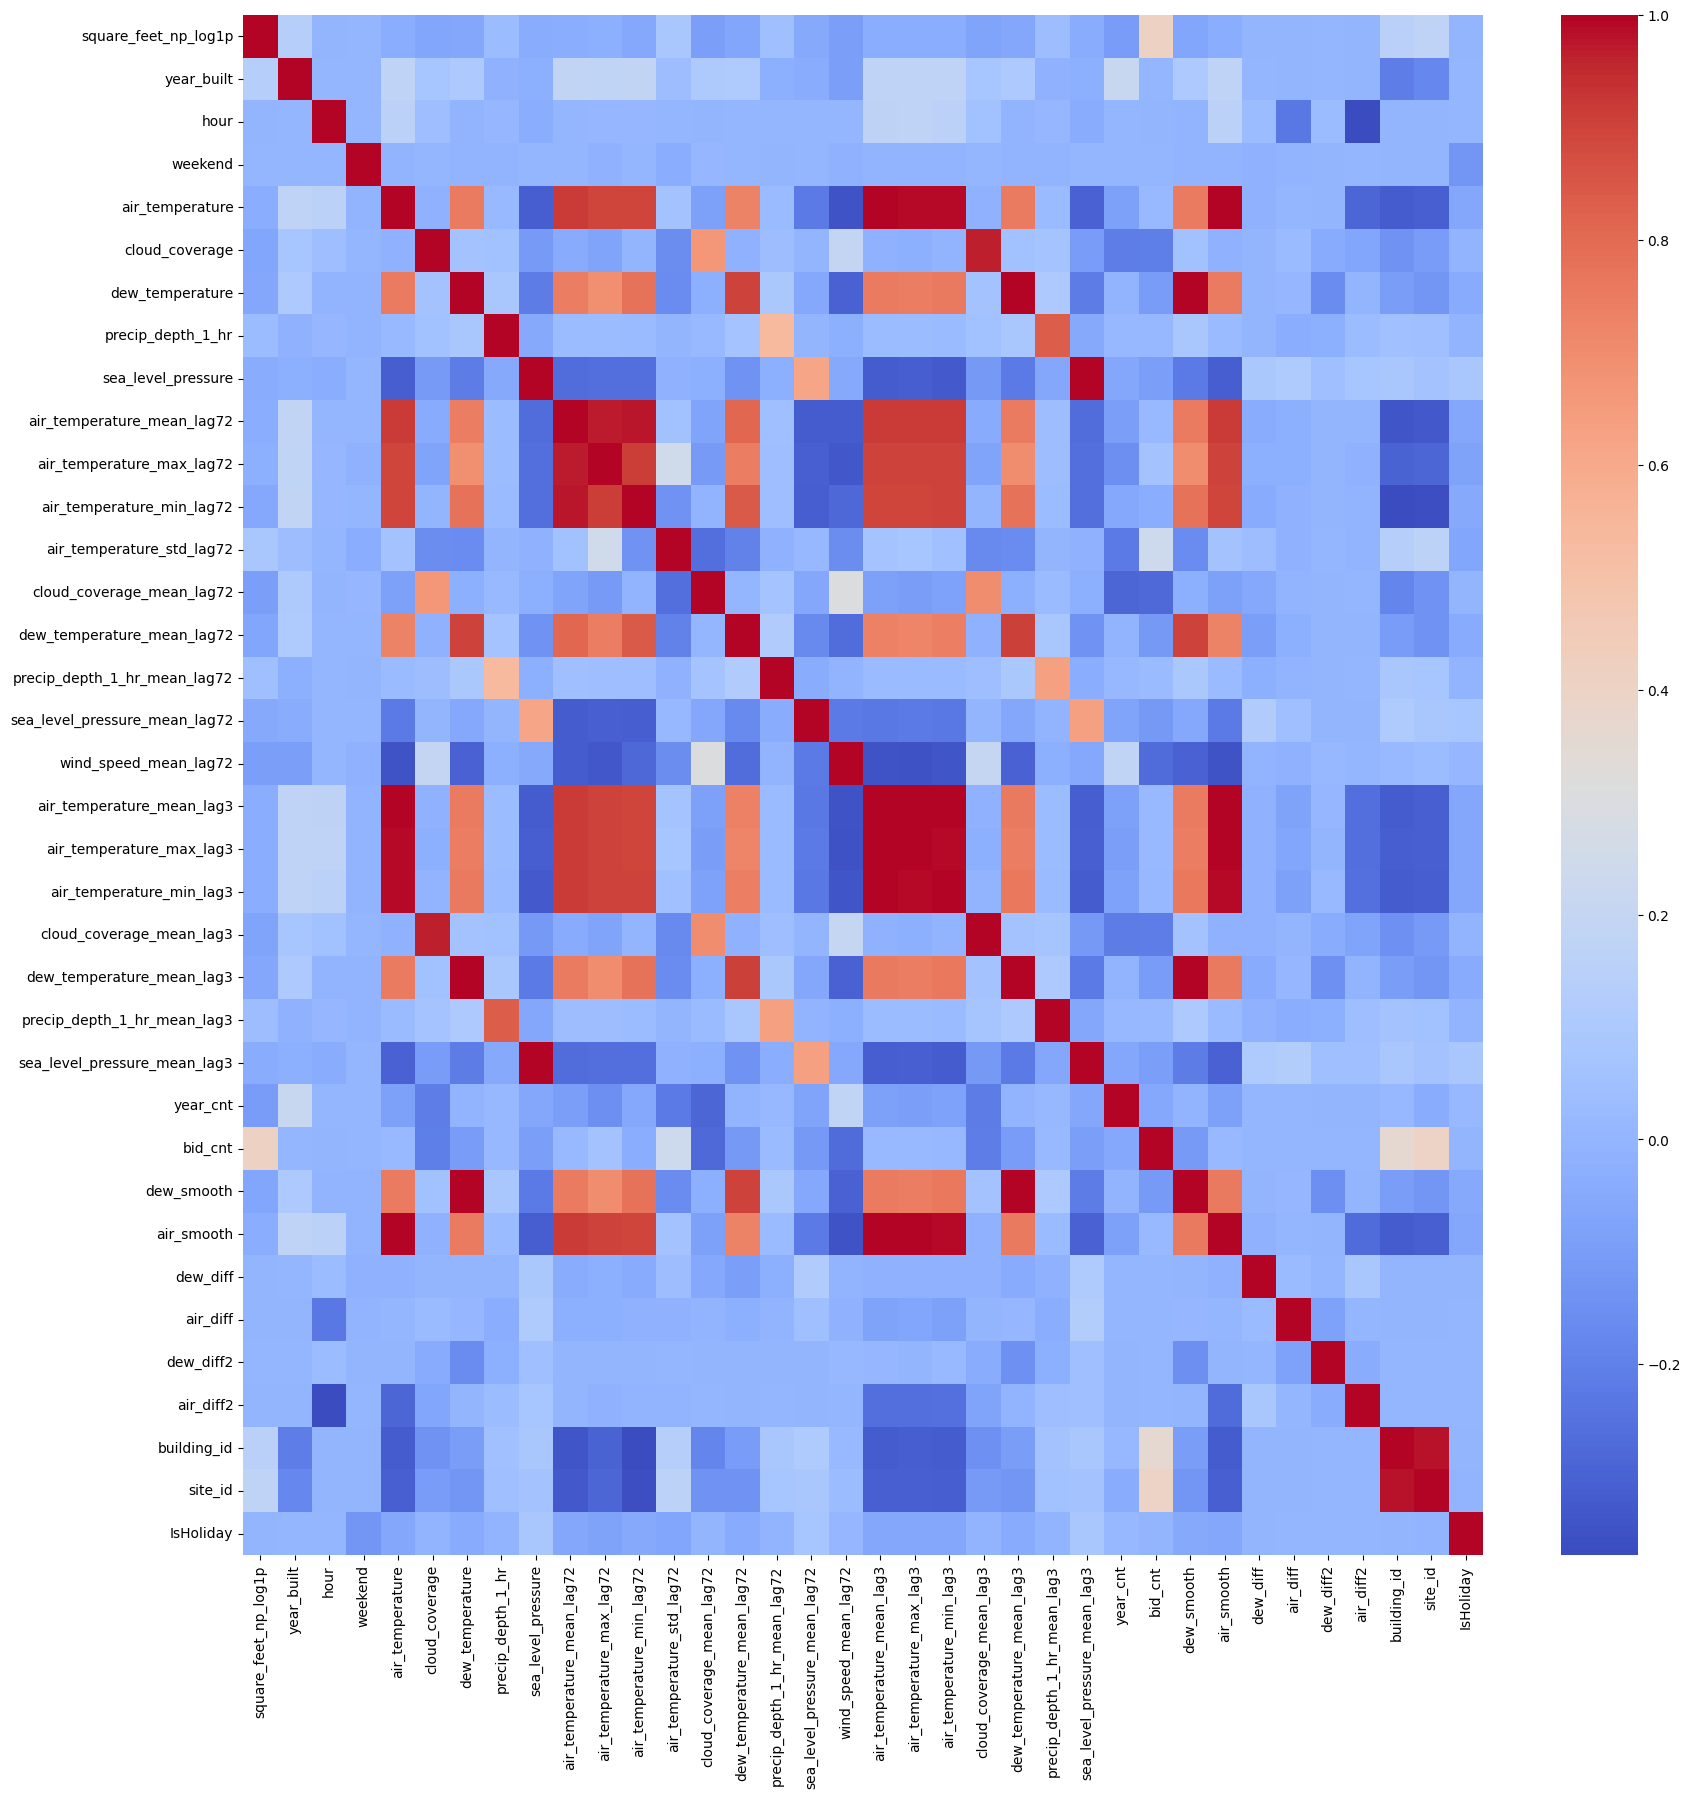

10677

In [11]:
X_train_subset = X_train[feature_cols + category_cols].sample(
    frac=0.1, random_state=42)
corr = X_train_subset.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=False, fmt='.2f', cmap='coolwarm')
plt.show()

del X_train_subset
gc.collect()

In [12]:
print("Normalizing the features...")
scaler = StandardScaler()
X_train[feature_cols] = scaler.fit_transform(X_train[feature_cols])
X_val[feature_cols] = scaler.transform(X_val[feature_cols])

Normalizing the features...


In [13]:
print("label encoding the categorical features...")
for col in category_cols:
   le = LabelEncoder()
   X_train[col] = le.fit_transform(X_train[col])
   X_val[col] = le.transform(X_val[col])

label encoding the categorical features...


In [14]:
print('Dtype of the categorical features after label encoding: ', X_train[category_cols].dtypes)

# # %% One-hot encode the categorical features
# print("One-hot encoding the categorical features...")
# X_train = pd.get_dummies(X_train, columns=category_cols)
# X_val = pd.get_dummies(X_val, columns=category_cols)

Dtype of the categorical features after label encoding:  building_id    int64
site_id        int64
primary_use    int64
IsHoliday      int64
dtype: object


In [15]:
print("Scaling the categorical features...")
scaler = StandardScaler()
X_train[category_cols] = scaler.fit_transform(X_train[category_cols])
X_val[category_cols] = scaler.transform(X_val[category_cols])

# # %% Encode categorical features and use MaxMinScaler to scale the features

# # Encode categorical features
# for col in category_cols:
#     le = LabelEncoder()
#     train_df[col] = le.fit_transform(train_df[col])

# # Scale features
# scaler = MinMaxScaler()
# train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])

# # %% Print the head of the data with the encoded categorical features
# print(train_df[category_cols].head())

# # %% Print the head of the data with the scaled features
# print(train_df[feature_cols].head())

Scaling the categorical features...


In [16]:
print('Shape of the training dataset: ', X_train[feature_cols + category_cols].shape)
print('Shape of the validation dataset: ', X_val[feature_cols + category_cols].shape)
print('Shape of the training labels: ', y_train.shape)
print('Shape of the validation labels: ', y_val.shape)

Shape of the training dataset:  (15565267, 37)
Shape of the validation dataset:  (3891317, 37)
Shape of the training labels:  (15565267,)
Shape of the validation labels:  (3891317,)


In [17]:
def create_model(input_shape):
    # Build 1D CNN autoencoder
    model = Sequential()
    model.add(Conv1D(16, kernel_size=1,
              activation='sigmoid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(32, kernel_size=1, activation='sigmoid'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(64, kernel_size=1, activation='sigmoid'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, kernel_size=1, activation='sigmoid'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear'))
    return model 
    # Add gradient clipping

Group Number:  80
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 37, 16)            32        
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 18, 16)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 18, 32)            544       
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 9, 32)            0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 9, 64)             2112      
                                                                 
 max_pooling1d_6 (MaxPooling  (None,

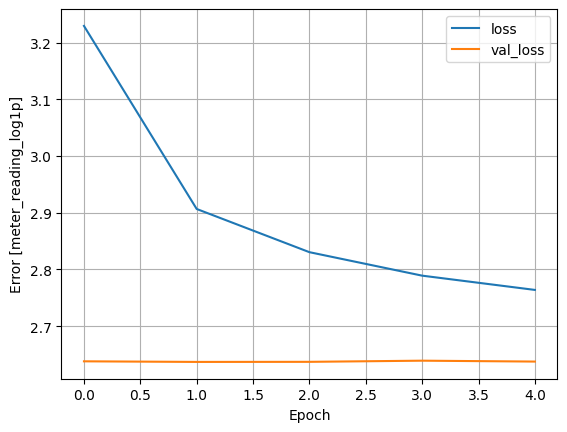

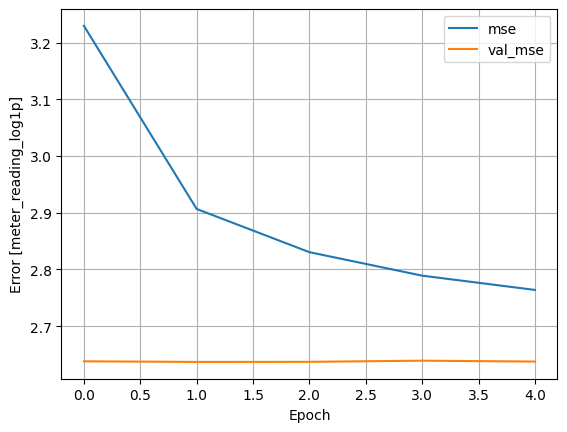

3479/3479 [==============================] - 6s 2ms/step
Group Number:  100
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 37, 16)            32        
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 18, 16)           0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 18, 32)            544       
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 9, 32)            0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 9, 64)             2112      
                                            

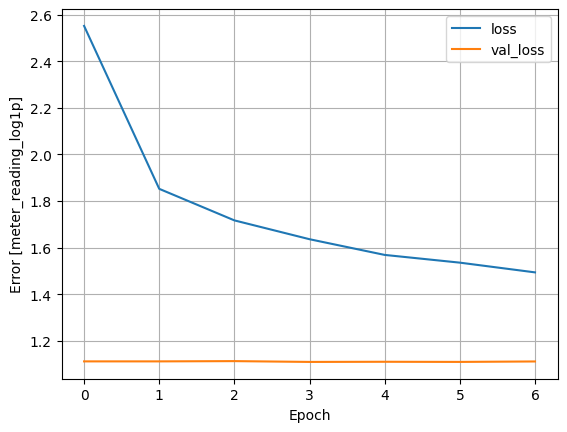

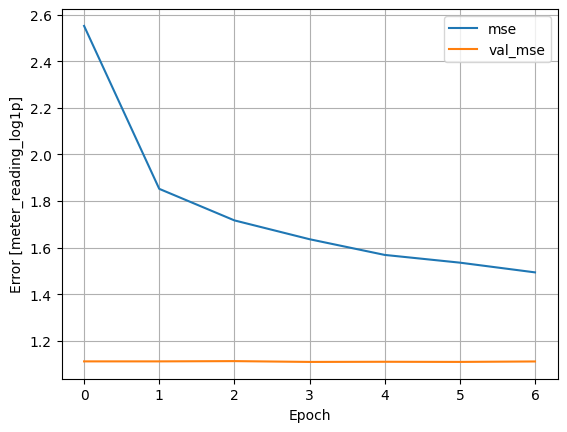

1476/1476 [==============================] - 2s 1ms/step
Group Number:  91
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 37, 16)            32        
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 18, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 18, 32)            544       
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 9, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 9, 64)             2112      
                                             

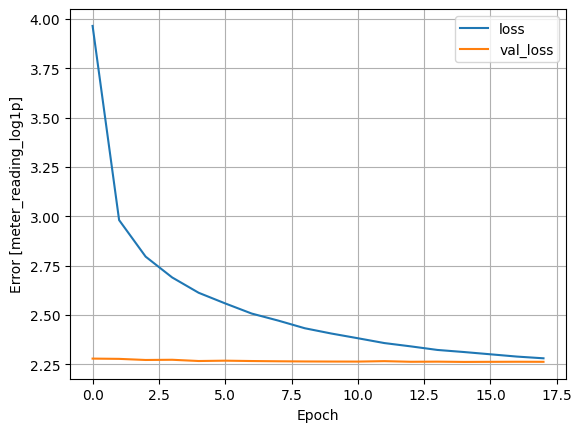

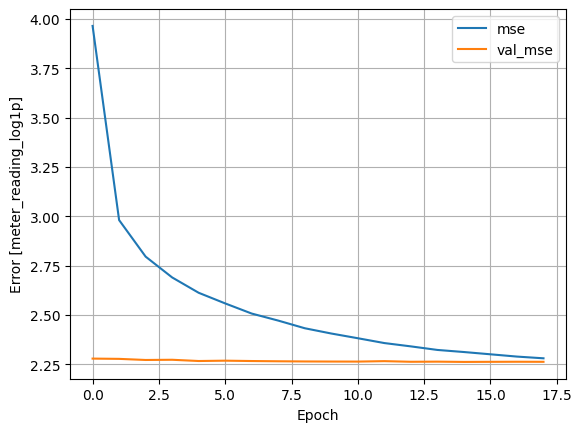

4949/4949 [==============================] - 6s 1ms/step
Group Number:  140
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 37, 16)            32        
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 18, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, 18, 32)            544       
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 9, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_18 (Conv1D)          (None, 9, 64)             2112      
                                            

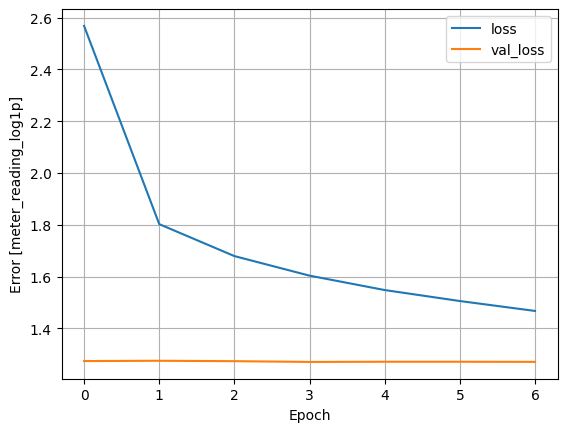

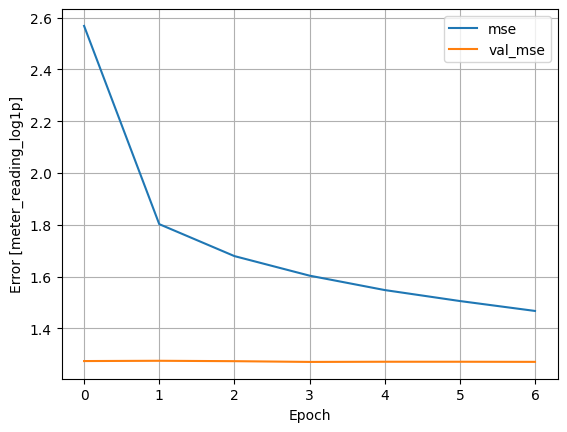

5317/5317 [==============================] - 6s 1ms/step
Group Number:  131
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 37, 16)            32        
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 18, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_21 (Conv1D)          (None, 18, 32)            544       
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 9, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_22 (Conv1D)          (None, 9, 64)             2112      
                                            

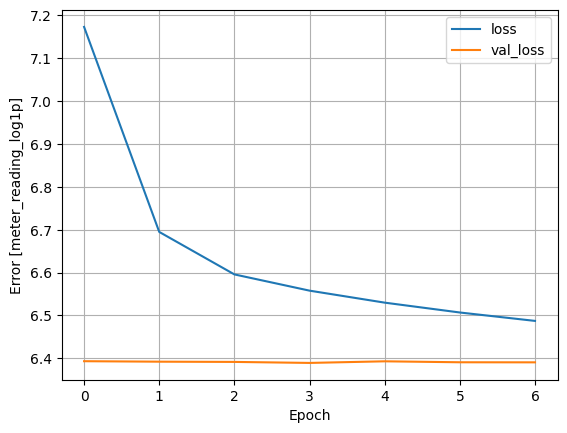

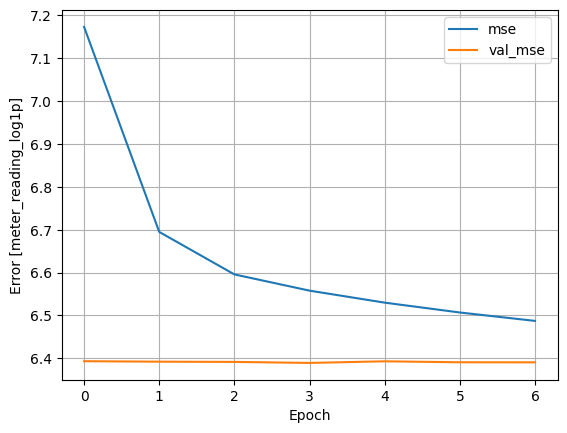

4392/4392 [==============================] - 5s 1ms/step
Group Number:  130
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 37, 16)            32        
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 18, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_25 (Conv1D)          (None, 18, 32)            544       
                                                                 
 max_pooling1d_25 (MaxPoolin  (None, 9, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_26 (Conv1D)          (None, 9, 64)             2112      
                                            

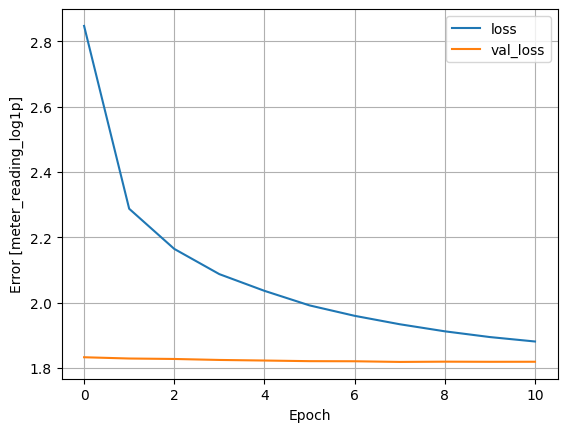

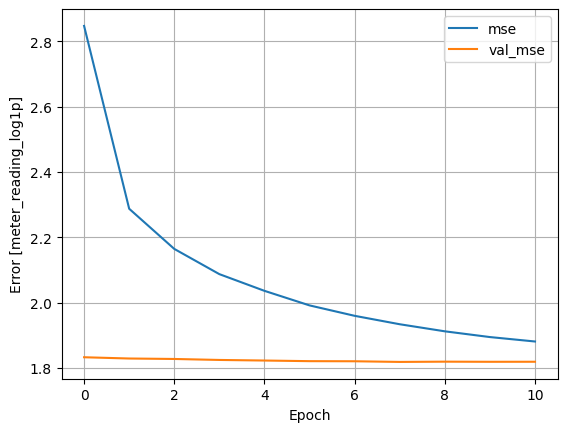

7534/7534 [==============================] - 9s 1ms/step
Group Number:  141
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_28 (Conv1D)          (None, 37, 16)            32        
                                                                 
 max_pooling1d_28 (MaxPoolin  (None, 18, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_29 (Conv1D)          (None, 18, 32)            544       
                                                                 
 max_pooling1d_29 (MaxPoolin  (None, 9, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_30 (Conv1D)          (None, 9, 64)             2112      
                                            

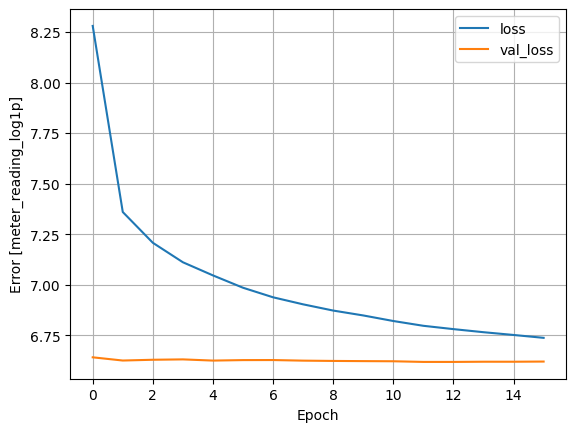

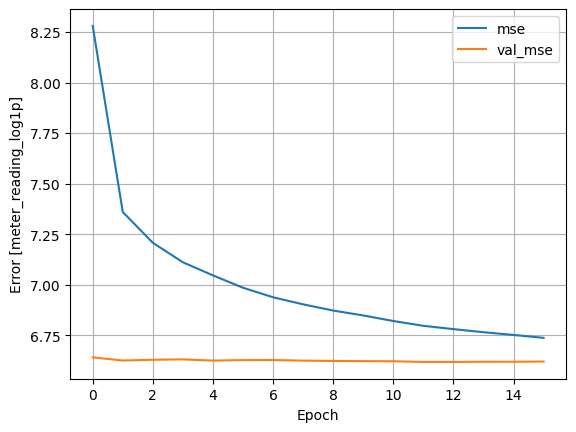

4483/4483 [==============================] - 5s 1ms/step
Group Number:  60
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_32 (Conv1D)          (None, 37, 16)            32        
                                                                 
 max_pooling1d_32 (MaxPoolin  (None, 18, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_33 (Conv1D)          (None, 18, 32)            544       
                                                                 
 max_pooling1d_33 (MaxPoolin  (None, 9, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_34 (Conv1D)          (None, 9, 64)             2112      
                                             

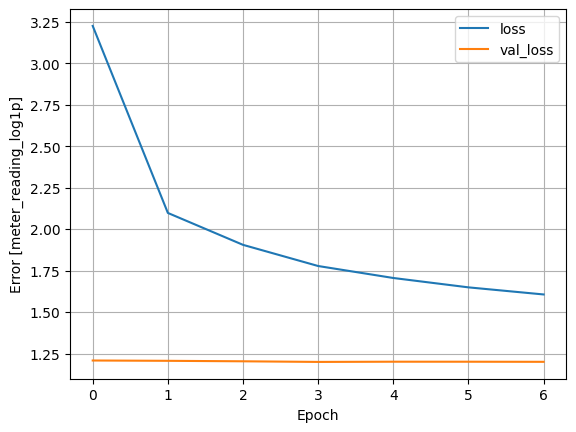

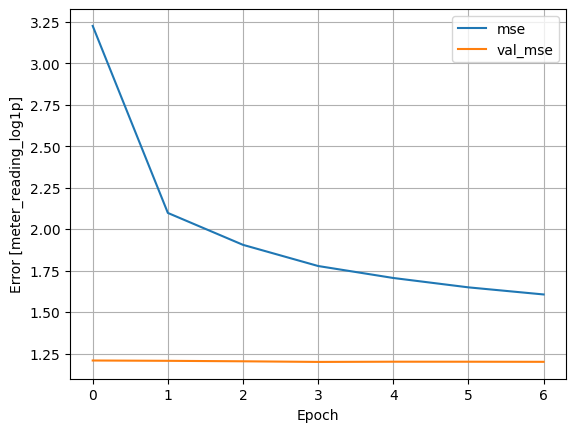

1935/1935 [==============================] - 2s 1ms/step
Group Number:  142
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_36 (Conv1D)          (None, 37, 16)            32        
                                                                 
 max_pooling1d_36 (MaxPoolin  (None, 18, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_37 (Conv1D)          (None, 18, 32)            544       
                                                                 
 max_pooling1d_37 (MaxPoolin  (None, 9, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_38 (Conv1D)          (None, 9, 64)             2112      
                                            

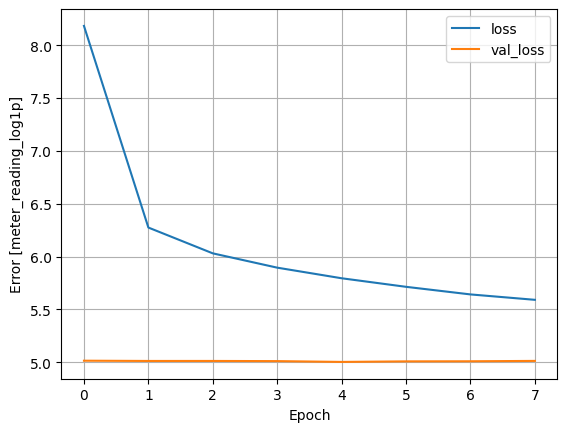

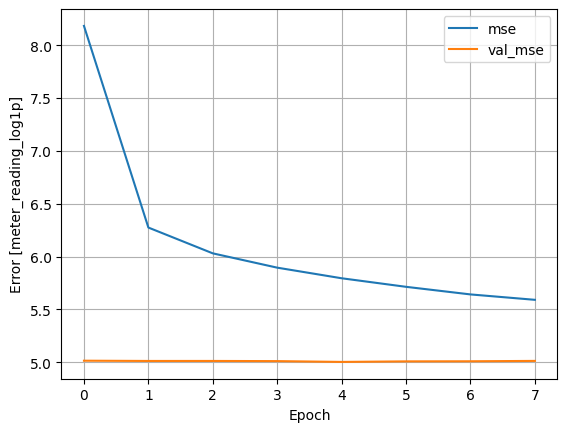

2164/2164 [==============================] - 3s 1ms/step
Group Number:  20
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_40 (Conv1D)          (None, 37, 16)            32        
                                                                 
 max_pooling1d_40 (MaxPoolin  (None, 18, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_41 (Conv1D)          (None, 18, 32)            544       
                                                                 
 max_pooling1d_41 (MaxPoolin  (None, 9, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_42 (Conv1D)          (None, 9, 64)             2112      
                                            

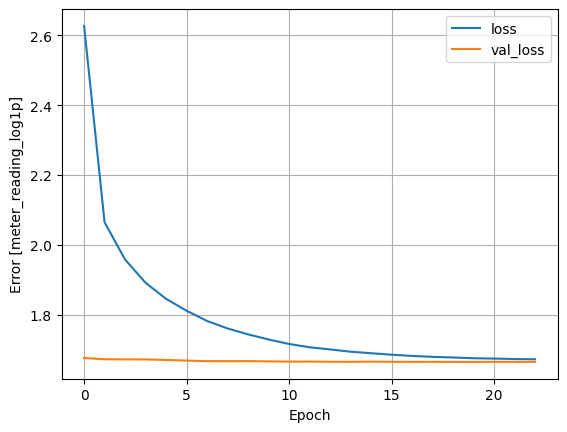

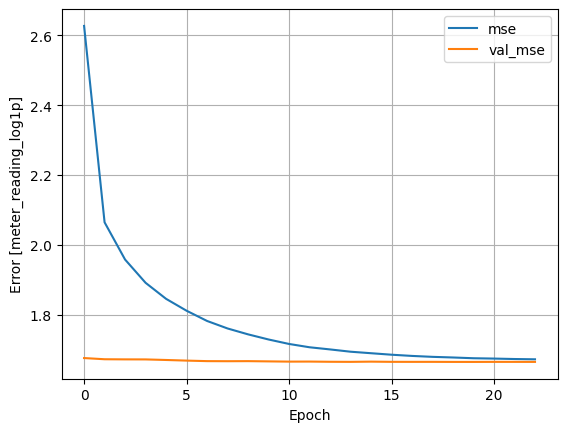

7234/7234 [==============================] - 8s 1ms/step
Group Number:  30
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_44 (Conv1D)          (None, 37, 16)            32        
                                                                 
 max_pooling1d_44 (MaxPoolin  (None, 18, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_45 (Conv1D)          (None, 18, 32)            544       
                                                                 
 max_pooling1d_45 (MaxPoolin  (None, 9, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_46 (Conv1D)          (None, 9, 64)             2112      
                                            

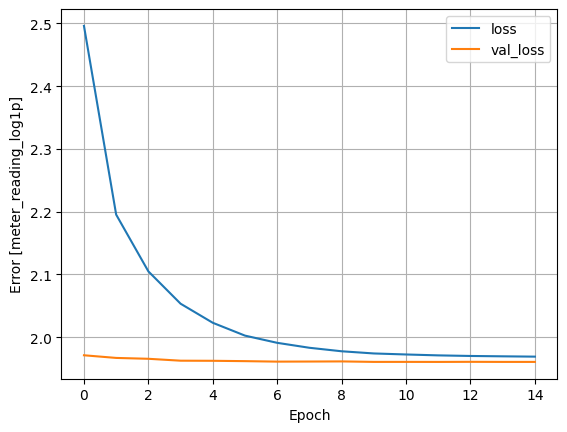

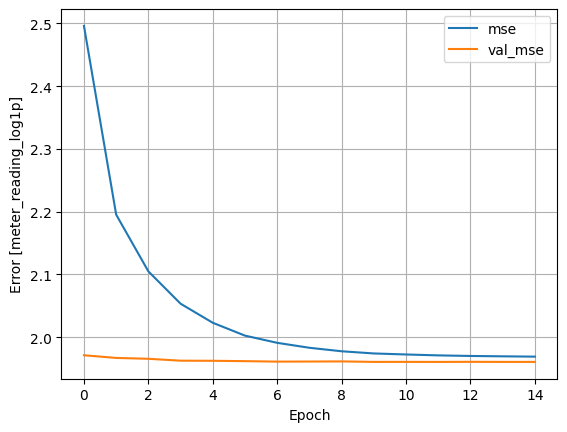

14806/14806 [==============================] - 18s 1ms/step
Group Number:  40
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_48 (Conv1D)          (None, 37, 16)            32        
                                                                 
 max_pooling1d_48 (MaxPoolin  (None, 18, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_49 (Conv1D)          (None, 18, 32)            544       
                                                                 
 max_pooling1d_49 (MaxPoolin  (None, 9, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_50 (Conv1D)          (None, 9, 64)             2112      
                                         

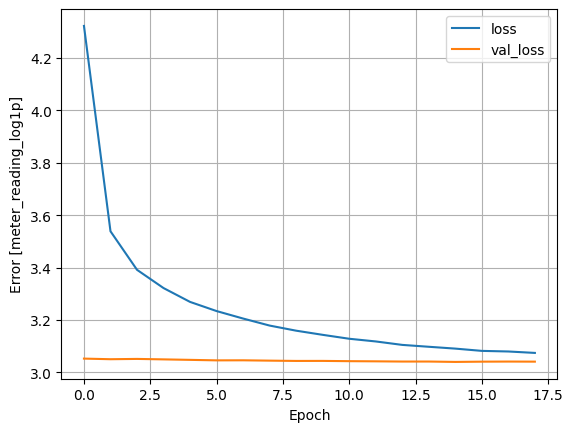

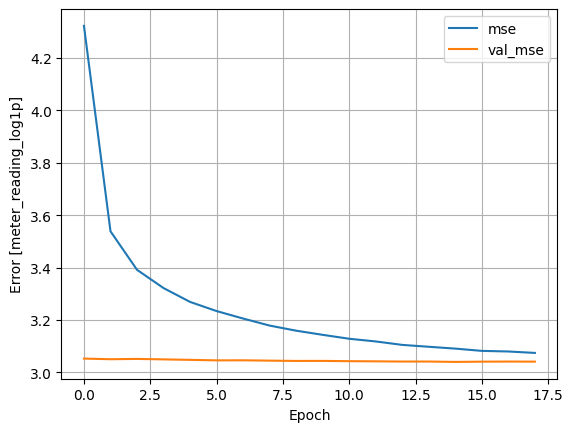

4666/4666 [==============================] - 6s 1ms/step
Group Number:  50
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_52 (Conv1D)          (None, 37, 16)            32        
                                                                 
 max_pooling1d_52 (MaxPoolin  (None, 18, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_53 (Conv1D)          (None, 18, 32)            544       
                                                                 
 max_pooling1d_53 (MaxPoolin  (None, 9, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_54 (Conv1D)          (None, 9, 64)             2112      
                                            

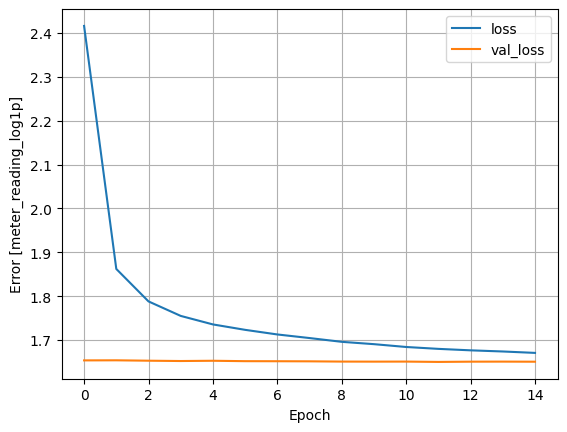

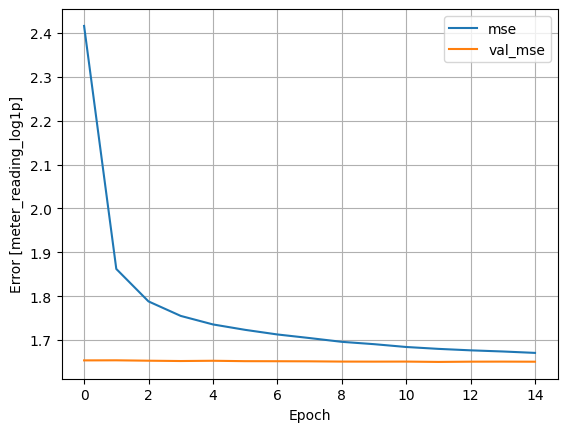

4847/4847 [==============================] - 6s 1ms/step
Group Number:  92
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_56 (Conv1D)          (None, 37, 16)            32        
                                                                 
 max_pooling1d_56 (MaxPoolin  (None, 18, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_57 (Conv1D)          (None, 18, 32)            544       
                                                                 
 max_pooling1d_57 (MaxPoolin  (None, 9, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_58 (Conv1D)          (None, 9, 64)             2112      
                                            

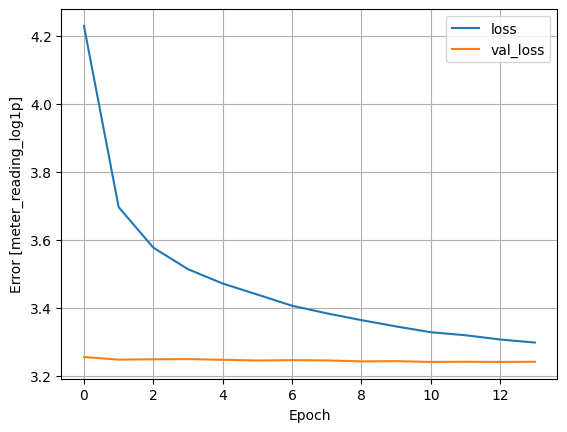

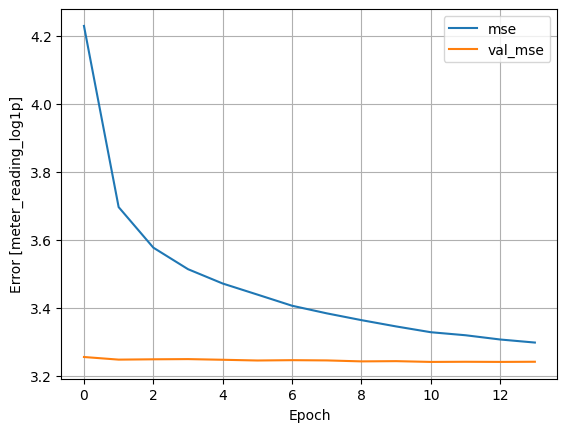

4614/4614 [==============================] - 6s 1ms/step
Group Number:  150
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_60 (Conv1D)          (None, 37, 16)            32        
                                                                 
 max_pooling1d_60 (MaxPoolin  (None, 18, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_61 (Conv1D)          (None, 18, 32)            544       
                                                                 
 max_pooling1d_61 (MaxPoolin  (None, 9, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_62 (Conv1D)          (None, 9, 64)             2112      
                                           

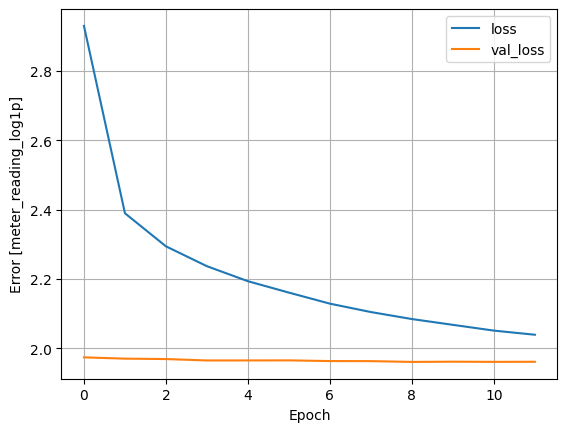

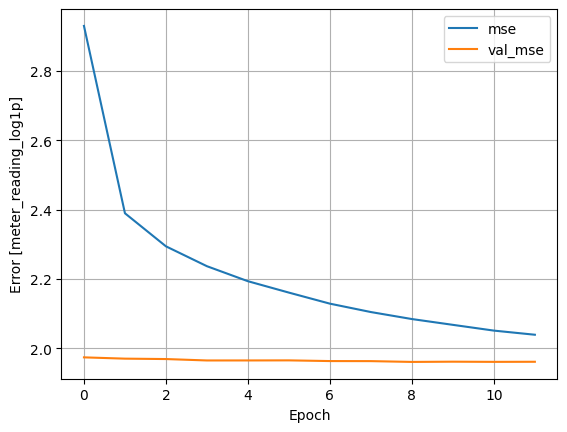

5235/5235 [==============================] - 7s 1ms/step
Group Number:  152
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_64 (Conv1D)          (None, 37, 16)            32        
                                                                 
 max_pooling1d_64 (MaxPoolin  (None, 18, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_65 (Conv1D)          (None, 18, 32)            544       
                                                                 
 max_pooling1d_65 (MaxPoolin  (None, 9, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_66 (Conv1D)          (None, 9, 64)             2112      
                                           

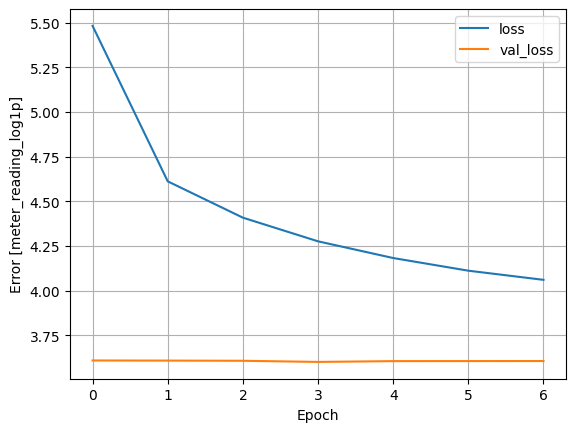

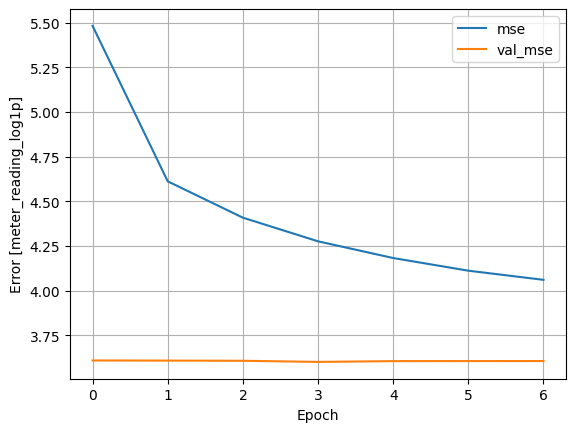

3085/3085 [==============================] - 4s 1ms/step
Group Number:  120
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_68 (Conv1D)          (None, 37, 16)            32        
                                                                 
 max_pooling1d_68 (MaxPoolin  (None, 18, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_69 (Conv1D)          (None, 18, 32)            544       
                                                                 
 max_pooling1d_69 (MaxPoolin  (None, 9, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_70 (Conv1D)          (None, 9, 64)             2112      
                                           

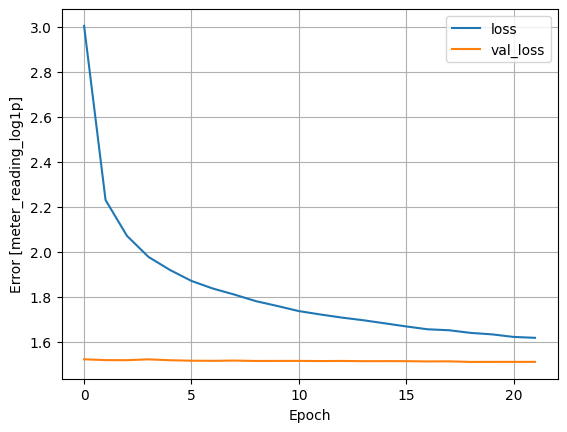

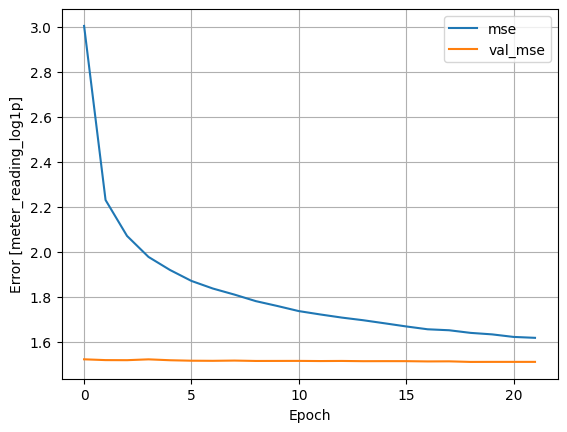

1975/1975 [==============================] - 3s 1ms/step
Group Number:  132
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_72 (Conv1D)          (None, 37, 16)            32        
                                                                 
 max_pooling1d_72 (MaxPoolin  (None, 18, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_73 (Conv1D)          (None, 18, 32)            544       
                                                                 
 max_pooling1d_73 (MaxPoolin  (None, 9, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_74 (Conv1D)          (None, 9, 64)             2112      
                                           

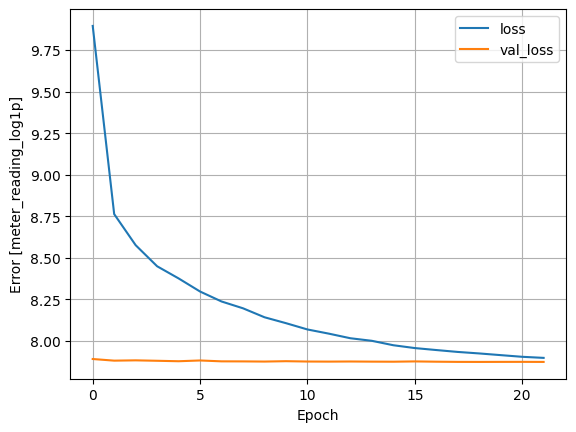

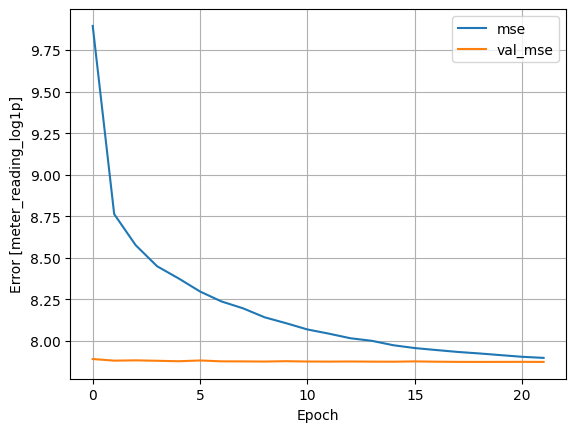

4774/4774 [==============================] - 6s 1ms/step
Group Number:  0
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_76 (Conv1D)          (None, 37, 16)            32        
                                                                 
 max_pooling1d_76 (MaxPoolin  (None, 18, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_77 (Conv1D)          (None, 18, 32)            544       
                                                                 
 max_pooling1d_77 (MaxPoolin  (None, 9, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_78 (Conv1D)          (None, 9, 64)             2112      
                                             

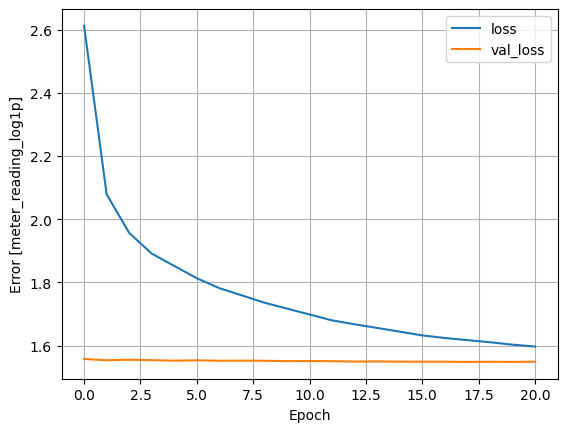

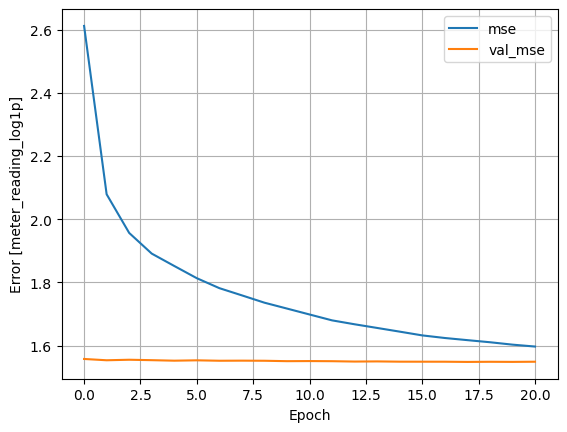

3459/3459 [==============================] - 4s 1ms/step
Group Number:  23
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_80 (Conv1D)          (None, 37, 16)            32        
                                                                 
 max_pooling1d_80 (MaxPoolin  (None, 18, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_81 (Conv1D)          (None, 18, 32)            544       
                                                                 
 max_pooling1d_81 (MaxPoolin  (None, 9, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_82 (Conv1D)          (None, 9, 64)             2112      
                                            

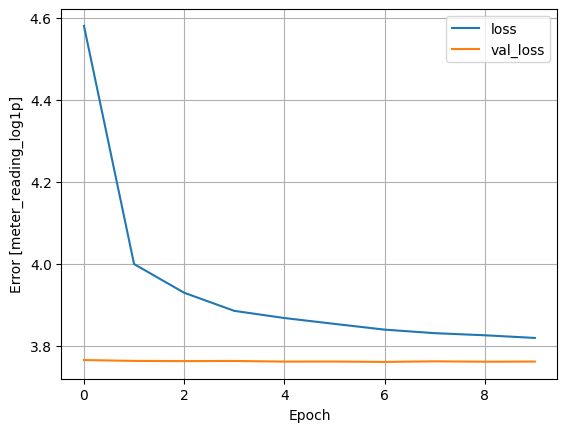

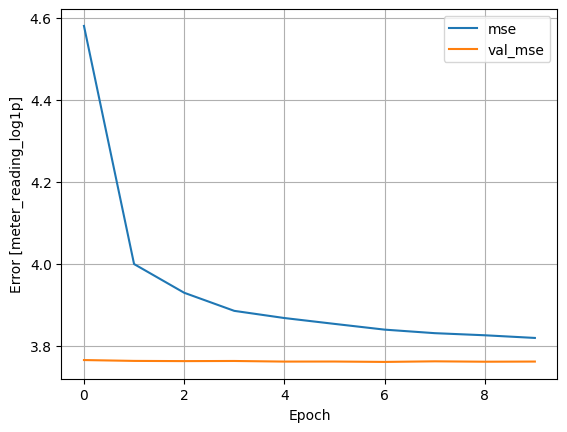

3012/3012 [==============================] - 4s 1ms/step
Group Number:  1
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_84 (Conv1D)          (None, 37, 16)            32        
                                                                 
 max_pooling1d_84 (MaxPoolin  (None, 18, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_85 (Conv1D)          (None, 18, 32)            544       
                                                                 
 max_pooling1d_85 (MaxPoolin  (None, 9, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_86 (Conv1D)          (None, 9, 64)             2112      
                                             

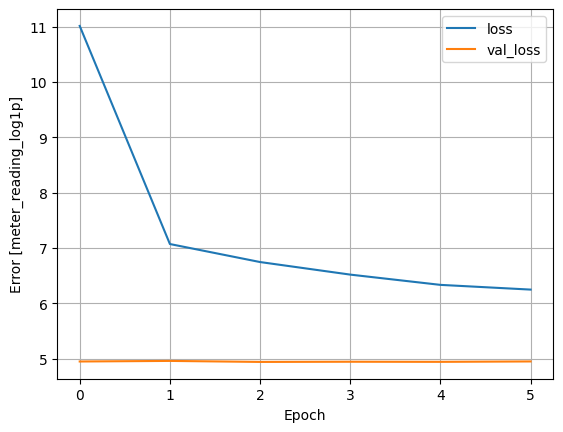

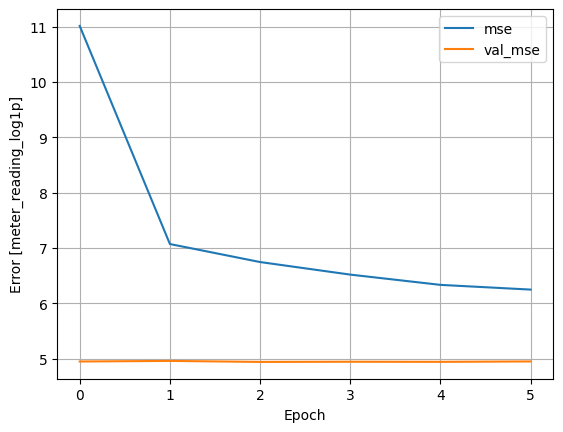

1027/1027 [==============================] - 1s 1ms/step
Group Number:  90
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_88 (Conv1D)          (None, 37, 16)            32        
                                                                 
 max_pooling1d_88 (MaxPoolin  (None, 18, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_89 (Conv1D)          (None, 18, 32)            544       
                                                                 
 max_pooling1d_89 (MaxPoolin  (None, 9, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_90 (Conv1D)          (None, 9, 64)             2112      
                                            

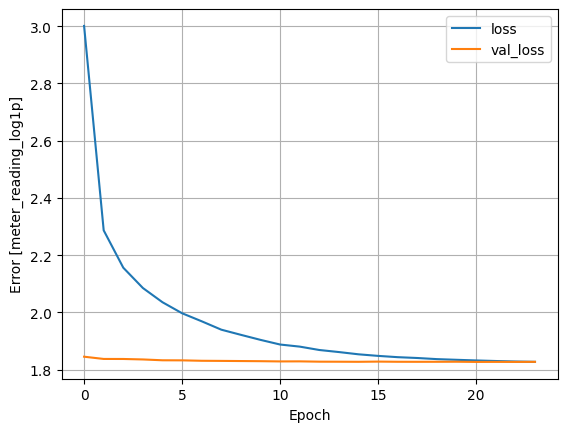

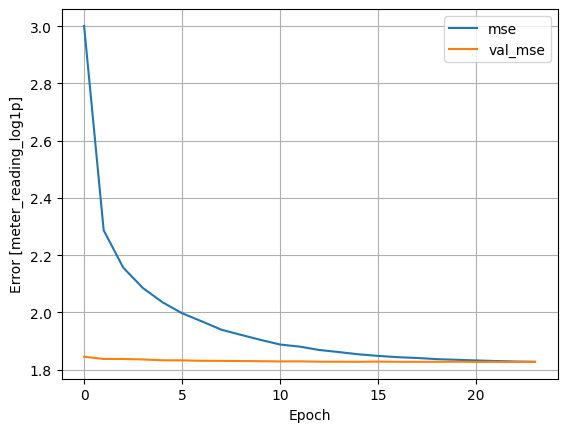

6326/6326 [==============================] - 8s 1ms/step
Group Number:  21
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_92 (Conv1D)          (None, 37, 16)            32        
                                                                 
 max_pooling1d_92 (MaxPoolin  (None, 18, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_93 (Conv1D)          (None, 18, 32)            544       
                                                                 
 max_pooling1d_93 (MaxPoolin  (None, 9, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_94 (Conv1D)          (None, 9, 64)             2112      
                                            

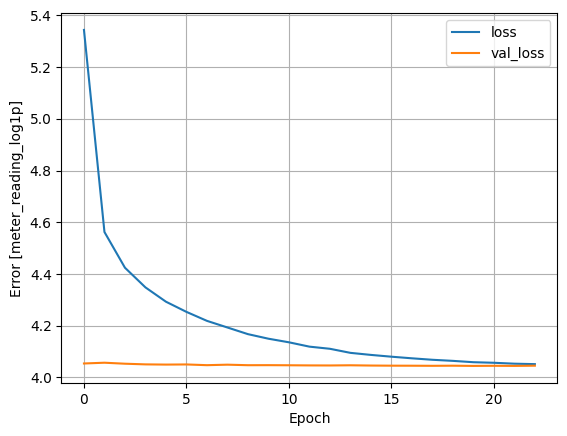

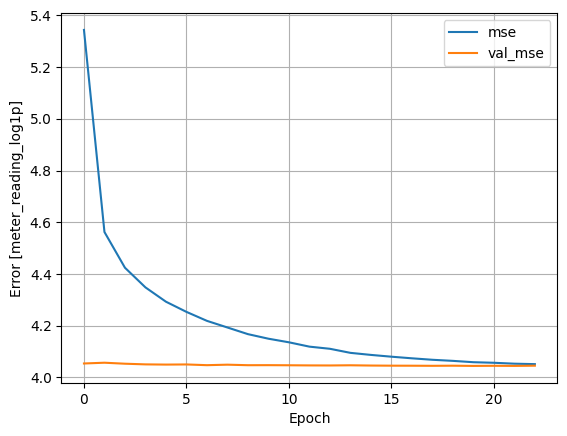

5251/5251 [==============================] - 6s 1ms/step
Group Number:  62
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_96 (Conv1D)          (None, 37, 16)            32        
                                                                 
 max_pooling1d_96 (MaxPoolin  (None, 18, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_97 (Conv1D)          (None, 18, 32)            544       
                                                                 
 max_pooling1d_97 (MaxPoolin  (None, 9, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_98 (Conv1D)          (None, 9, 64)             2112      
                                            

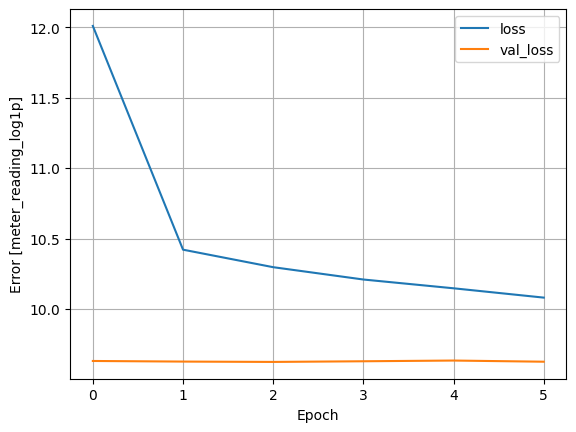

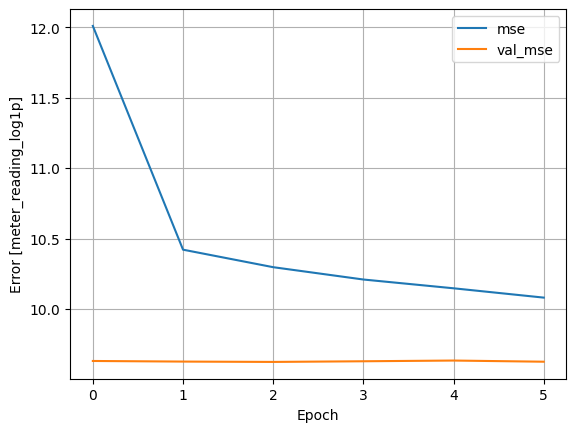

1179/1179 [==============================] - 2s 1ms/step
Group Number:  10
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_100 (Conv1D)         (None, 37, 16)            32        
                                                                 
 max_pooling1d_100 (MaxPooli  (None, 18, 16)           0         
 ng1D)                                                           
                                                                 
 conv1d_101 (Conv1D)         (None, 18, 32)            544       
                                                                 
 max_pooling1d_101 (MaxPooli  (None, 9, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_102 (Conv1D)         (None, 9, 64)             2112      
                                            

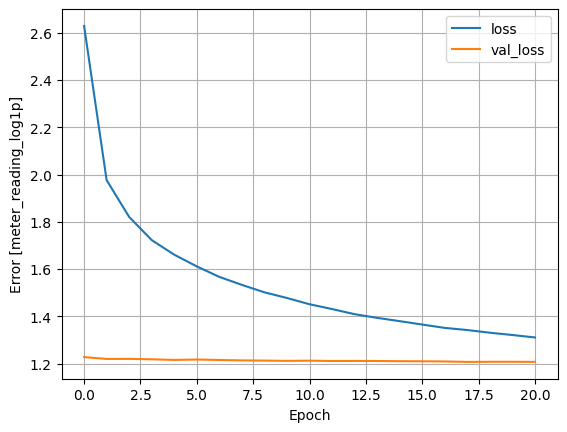

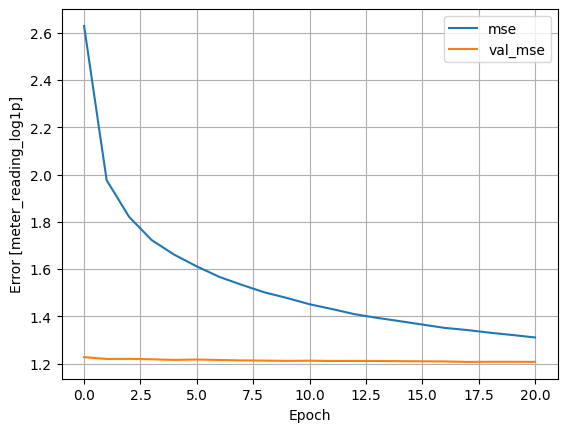

2641/2641 [==============================] - 3s 1ms/step
Group Number:  13
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_104 (Conv1D)         (None, 37, 16)            32        
                                                                 
 max_pooling1d_104 (MaxPooli  (None, 18, 16)           0         
 ng1D)                                                           
                                                                 
 conv1d_105 (Conv1D)         (None, 18, 32)            544       
                                                                 
 max_pooling1d_105 (MaxPooli  (None, 9, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_106 (Conv1D)         (None, 9, 64)             2112      
                                            

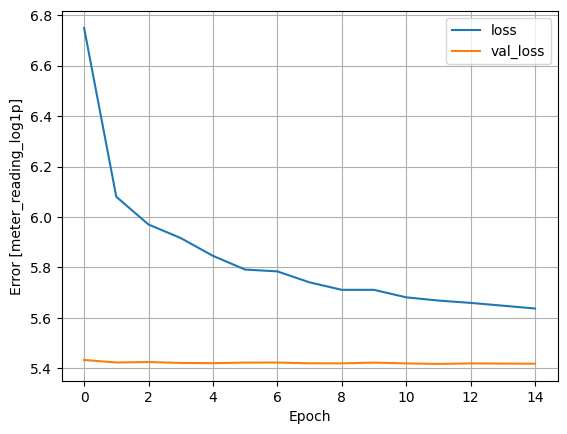

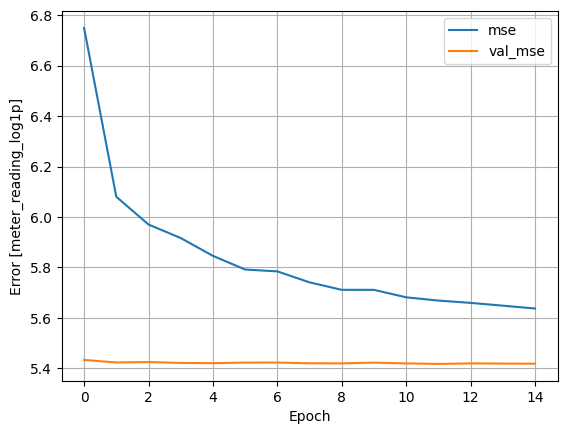

659/659 [==============================] - 1s 1ms/step
Group Number:  151
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_108 (Conv1D)         (None, 37, 16)            32        
                                                                 
 max_pooling1d_108 (MaxPooli  (None, 18, 16)           0         
 ng1D)                                                           
                                                                 
 conv1d_109 (Conv1D)         (None, 18, 32)            544       
                                                                 
 max_pooling1d_109 (MaxPooli  (None, 9, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_110 (Conv1D)         (None, 9, 64)             2112      
                                             

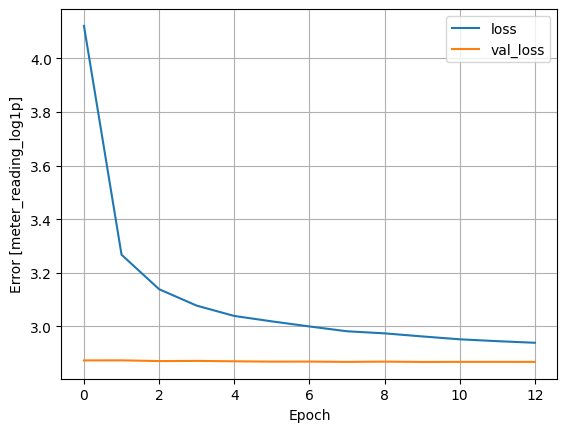

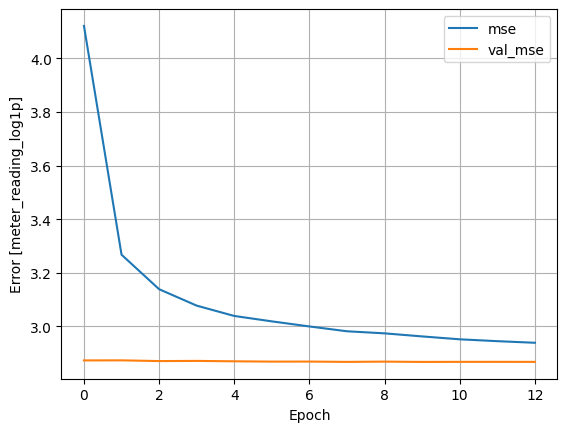

2906/2906 [==============================] - 3s 1ms/step
Group Number:  72
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_112 (Conv1D)         (None, 37, 16)            32        
                                                                 
 max_pooling1d_112 (MaxPooli  (None, 18, 16)           0         
 ng1D)                                                           
                                                                 
 conv1d_113 (Conv1D)         (None, 18, 32)            544       
                                                                 
 max_pooling1d_113 (MaxPooli  (None, 9, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_114 (Conv1D)         (None, 9, 64)             2112      
                                            

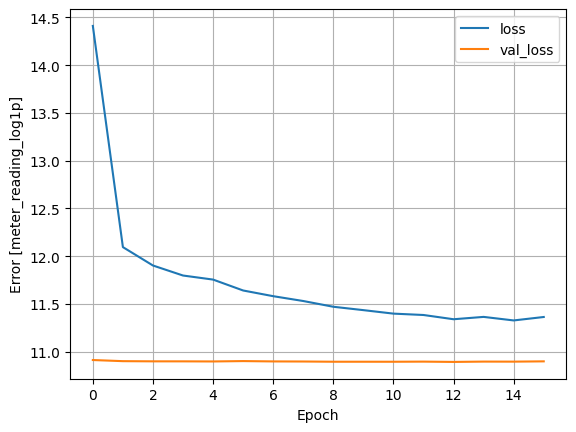

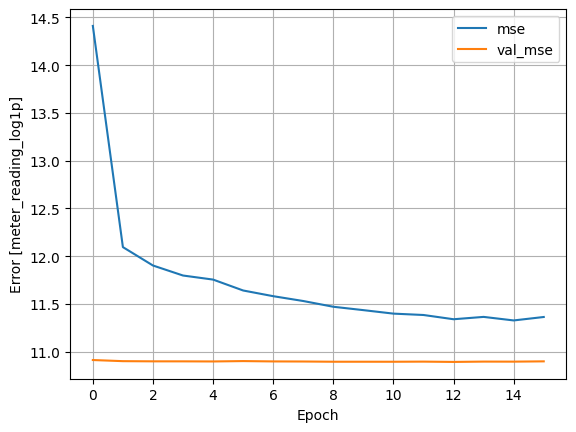

654/654 [==============================] - 1s 1ms/step
Group Number:  143
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_116 (Conv1D)         (None, 37, 16)            32        
                                                                 
 max_pooling1d_116 (MaxPooli  (None, 18, 16)           0         
 ng1D)                                                           
                                                                 
 conv1d_117 (Conv1D)         (None, 18, 32)            544       
                                                                 
 max_pooling1d_117 (MaxPooli  (None, 9, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_118 (Conv1D)         (None, 9, 64)             2112      
                                             

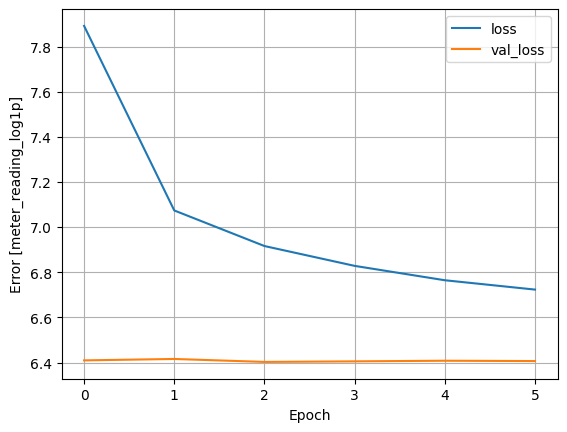

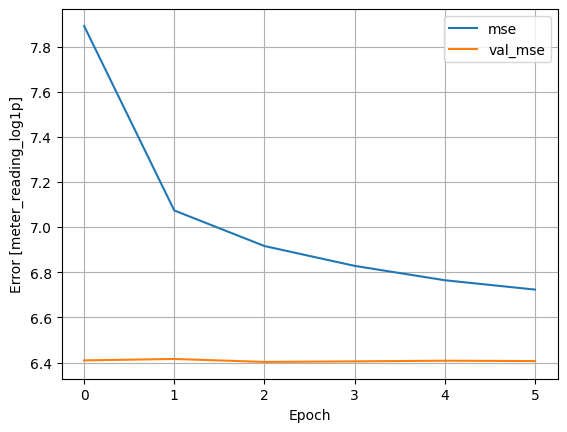

3046/3046 [==============================] - 4s 1ms/step
Group Number:  61
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_120 (Conv1D)         (None, 37, 16)            32        
                                                                 
 max_pooling1d_120 (MaxPooli  (None, 18, 16)           0         
 ng1D)                                                           
                                                                 
 conv1d_121 (Conv1D)         (None, 18, 32)            544       
                                                                 
 max_pooling1d_121 (MaxPooli  (None, 9, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_122 (Conv1D)         (None, 9, 64)             2112      
                                            

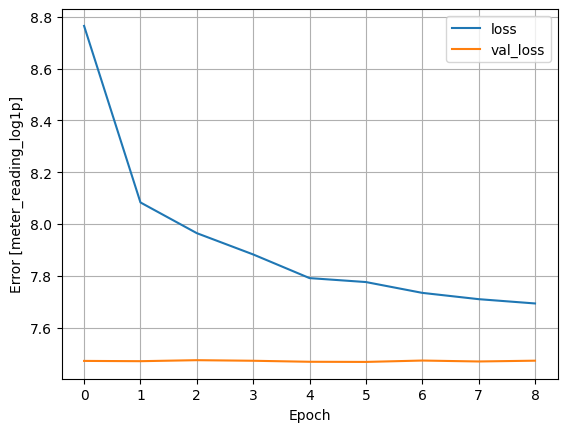

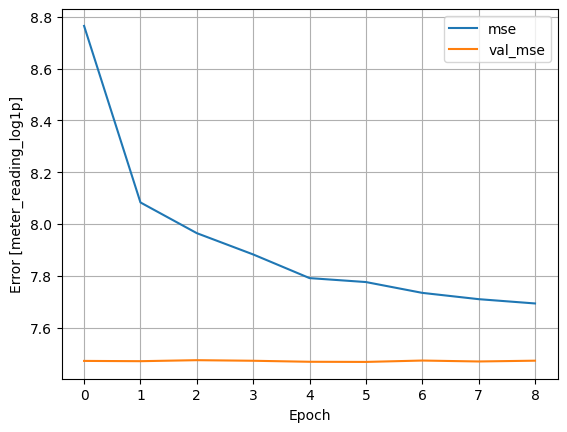

1010/1010 [==============================] - 1s 1ms/step
Group Number:  103
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_124 (Conv1D)         (None, 37, 16)            32        
                                                                 
 max_pooling1d_124 (MaxPooli  (None, 18, 16)           0         
 ng1D)                                                           
                                                                 
 conv1d_125 (Conv1D)         (None, 18, 32)            544       
                                                                 
 max_pooling1d_125 (MaxPooli  (None, 9, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_126 (Conv1D)         (None, 9, 64)             2112      
                                           

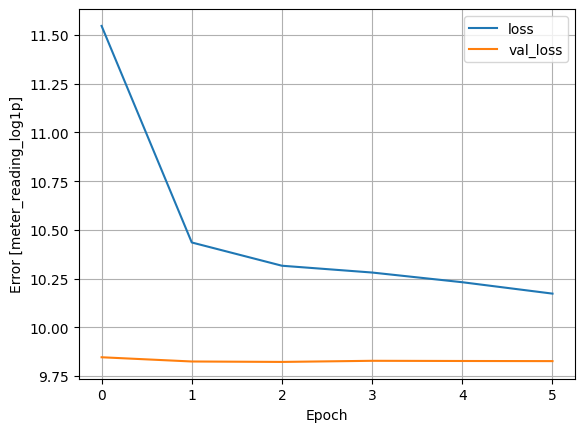

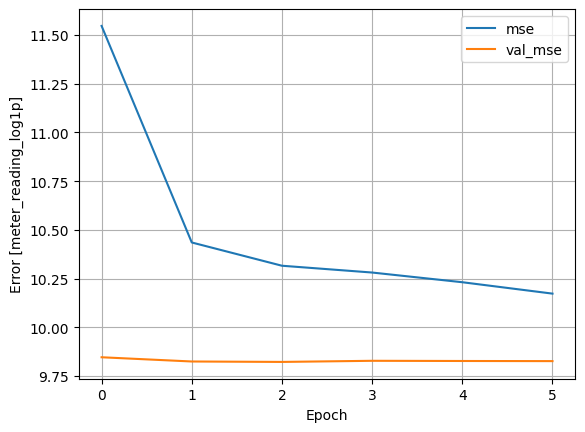

600/600 [==============================] - 1s 1ms/step
Group Number:  101
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_128 (Conv1D)         (None, 37, 16)            32        
                                                                 
 max_pooling1d_128 (MaxPooli  (None, 18, 16)           0         
 ng1D)                                                           
                                                                 
 conv1d_129 (Conv1D)         (None, 18, 32)            544       
                                                                 
 max_pooling1d_129 (MaxPooli  (None, 9, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_130 (Conv1D)         (None, 9, 64)             2112      
                                             

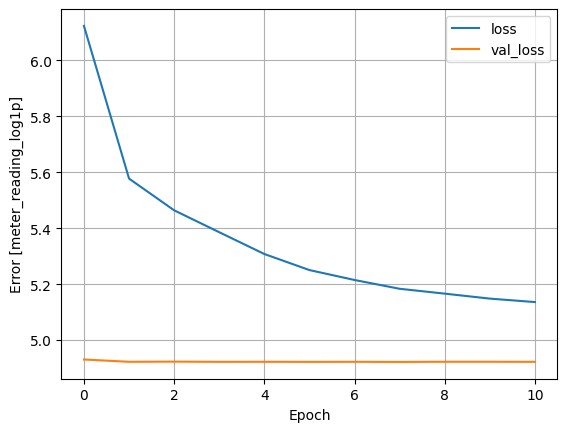

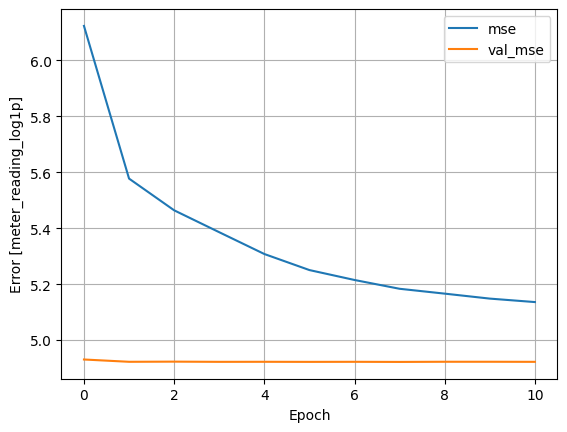

494/494 [==============================] - 1s 1ms/step
Group Number:  70
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_132 (Conv1D)         (None, 37, 16)            32        
                                                                 
 max_pooling1d_132 (MaxPooli  (None, 18, 16)           0         
 ng1D)                                                           
                                                                 
 conv1d_133 (Conv1D)         (None, 18, 32)            544       
                                                                 
 max_pooling1d_133 (MaxPooli  (None, 9, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_134 (Conv1D)         (None, 9, 64)             2112      
                                              

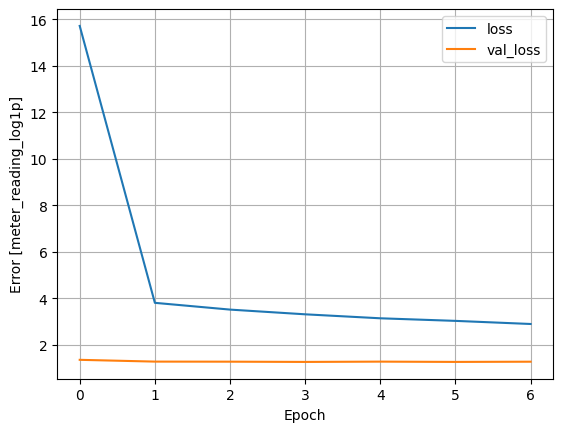

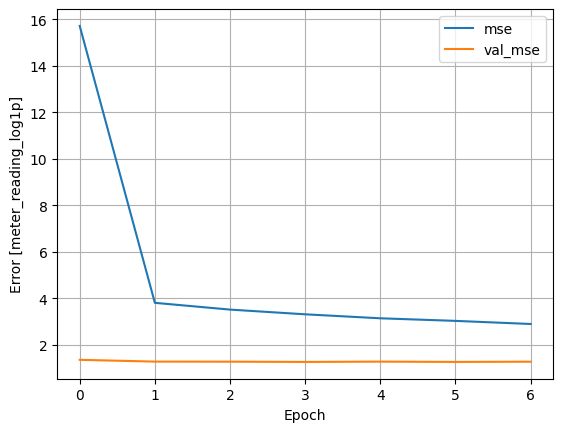

569/569 [==============================] - 1s 1ms/step
Group Number:  113
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_136 (Conv1D)         (None, 37, 16)            32        
                                                                 
 max_pooling1d_136 (MaxPooli  (None, 18, 16)           0         
 ng1D)                                                           
                                                                 
 conv1d_137 (Conv1D)         (None, 18, 32)            544       
                                                                 
 max_pooling1d_137 (MaxPooli  (None, 9, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_138 (Conv1D)         (None, 9, 64)             2112      
                                             

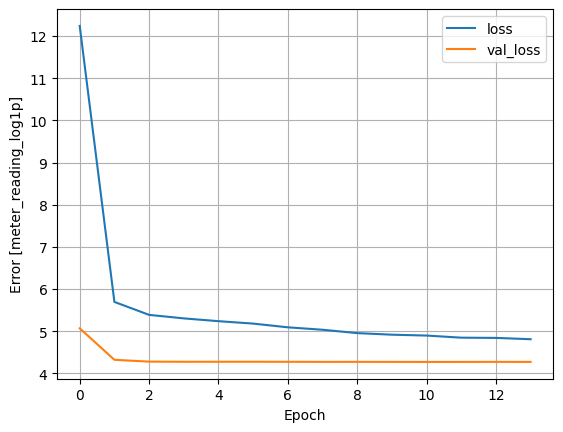

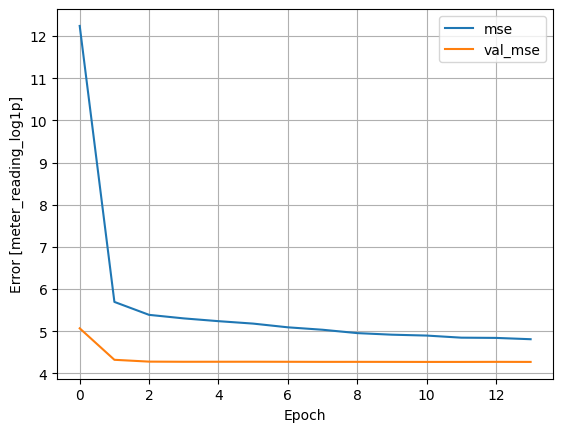

272/272 [==============================] - 0s 1ms/step
Group Number:  110
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_140 (Conv1D)         (None, 37, 16)            32        
                                                                 
 max_pooling1d_140 (MaxPooli  (None, 18, 16)           0         
 ng1D)                                                           
                                                                 
 conv1d_141 (Conv1D)         (None, 18, 32)            544       
                                                                 
 max_pooling1d_141 (MaxPooli  (None, 9, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_142 (Conv1D)         (None, 9, 64)             2112      
                                             

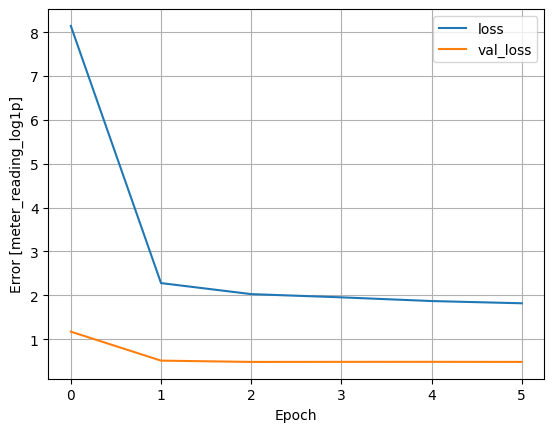

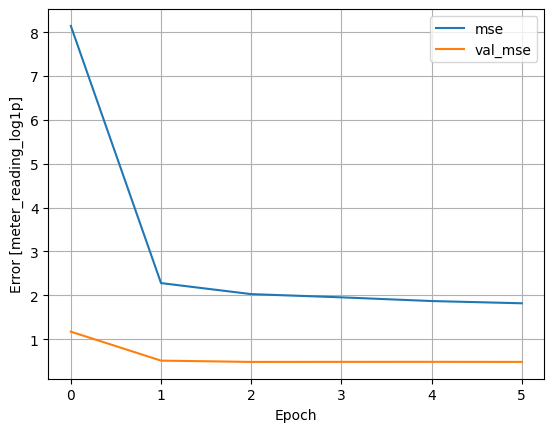

272/272 [==============================] - 0s 1ms/step
Group Number:  111
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_144 (Conv1D)         (None, 37, 16)            32        
                                                                 
 max_pooling1d_144 (MaxPooli  (None, 18, 16)           0         
 ng1D)                                                           
                                                                 
 conv1d_145 (Conv1D)         (None, 18, 32)            544       
                                                                 
 max_pooling1d_145 (MaxPooli  (None, 9, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_146 (Conv1D)         (None, 9, 64)             2112      
                                             

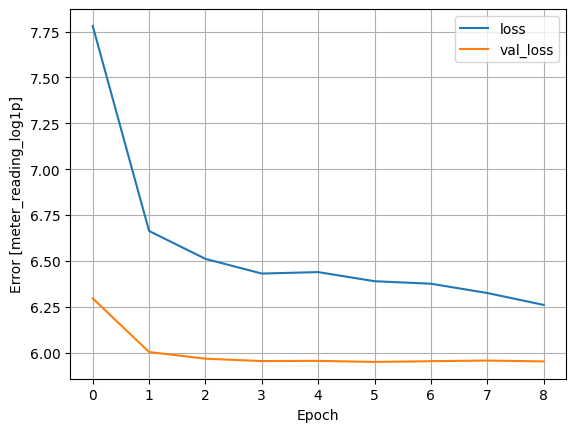

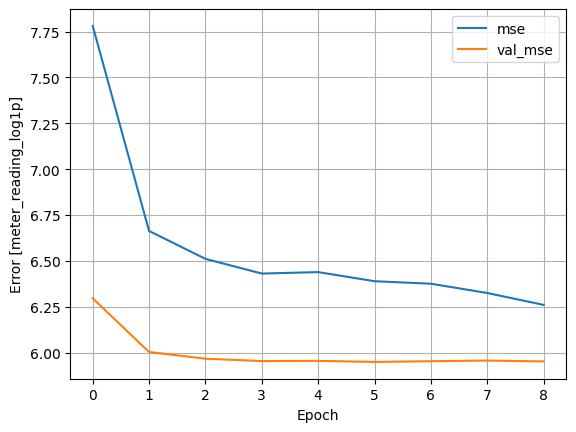

205/205 [==============================] - 0s 2ms/step
Group Number:  73
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_148 (Conv1D)         (None, 37, 16)            32        
                                                                 
 max_pooling1d_148 (MaxPooli  (None, 18, 16)           0         
 ng1D)                                                           
                                                                 
 conv1d_149 (Conv1D)         (None, 18, 32)            544       
                                                                 
 max_pooling1d_149 (MaxPooli  (None, 9, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_150 (Conv1D)         (None, 9, 64)             2112      
                                              

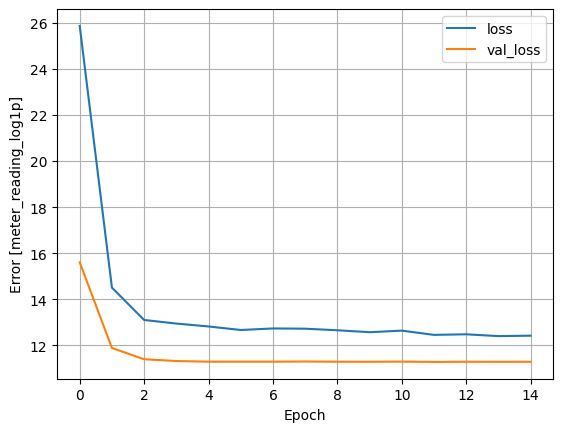

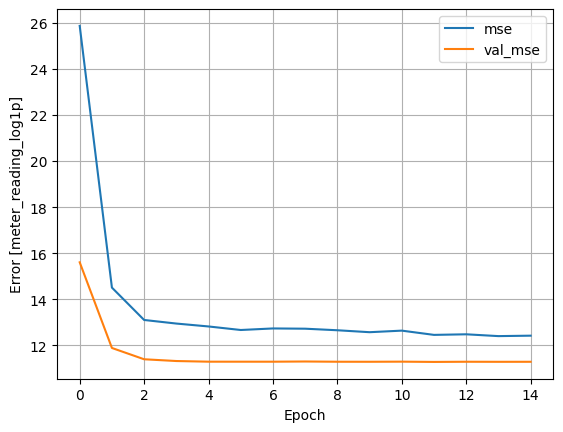

165/165 [==============================] - 0s 1ms/step
Group Number:  71
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_152 (Conv1D)         (None, 37, 16)            32        
                                                                 
 max_pooling1d_152 (MaxPooli  (None, 18, 16)           0         
 ng1D)                                                           
                                                                 
 conv1d_153 (Conv1D)         (None, 18, 32)            544       
                                                                 
 max_pooling1d_153 (MaxPooli  (None, 9, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_154 (Conv1D)         (None, 9, 64)             2112      
                                              

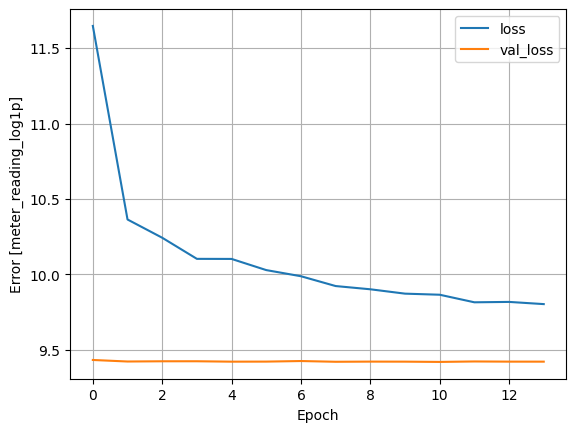

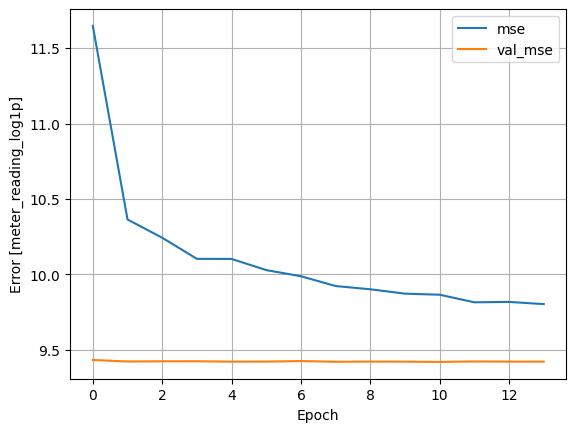

819/819 [==============================] - 1s 1ms/step
Group Number:  153
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_156 (Conv1D)         (None, 37, 16)            32        
                                                                 
 max_pooling1d_156 (MaxPooli  (None, 18, 16)           0         
 ng1D)                                                           
                                                                 
 conv1d_157 (Conv1D)         (None, 18, 32)            544       
                                                                 
 max_pooling1d_157 (MaxPooli  (None, 9, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_158 (Conv1D)         (None, 9, 64)             2112      
                                             

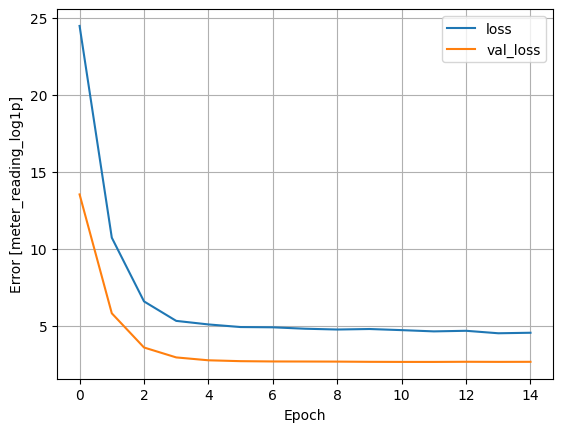

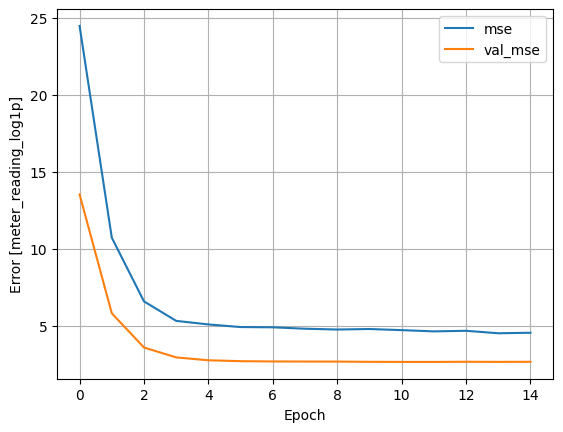

93/93 [==============================] - 0s 1ms/step


In [19]:
for groupNum in X_train['groupNum_train'].unique():
    print('Group Number: ', groupNum)
    # Trim the dataset based on the selected features and groupNum_train
    X_train_group = X_train[X_train['groupNum_train']
                            == groupNum][feature_cols + category_cols]
    X_val_group = X_val[X_val['groupNum_train']
                        == groupNum][feature_cols + category_cols]

    # Get the labels
    y_train_group = y_train[X_train['groupNum_train'] == groupNum]
    y_val_group = y_val[X_val['groupNum_train'] == groupNum]

    
    # Convert the dataset to numpy array
    X_train_group = X_train_group.values
    X_val_group = X_val_group.values

    # Reshape the dataset to batch_size, timesteps, features
    X_train_group = X_train_group.reshape(
        X_train_group.shape[0], X_train_group.shape[1], 1)
    X_val_group = X_val_group.reshape(
        X_val_group.shape[0], X_val_group.shape[1], 1)

    # Reshape the labels to batch_size, timesteps, features
    y_train_group = y_train_group.values.reshape(
        y_train_group.shape[0], 1, 1)
    y_val_group = y_val_group.values.reshape(
        y_val_group.shape[0], 1, 1)

    # Get the input shape
    input_shape = (X_train_group.shape[1], X_train_group.shape[2])

    #  Create the model
    model = create_model(input_shape)
    # Apply Gradient clipping
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
    #gvs = optimizer.get_gradients(model.total_loss, model.trainable_weights)
    #capped_gvs = [tf.clip_by_value(grad, -1., 1.) for grad in gvs]
    #optimizer.apply_gradients(zip(capped_gvs, model.trainable_weights))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])
    model.summary()



    # Early stopping and model checkpoint
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=3, mode='min')
    model_checkpoint = ModelCheckpoint(
        'model.h5', monitor='val_loss', save_best_only=True, mode='min')

    #  Train the model
    history = model.fit(X_train_group, y_train_group, epochs=100, batch_size=512, validation_data=(
        X_val_group, y_val_group), callbacks=[early_stopping, model_checkpoint])
    
    #  Plot the training and validation loss
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [meter_reading_log1p]')
    plt.legend()
    plt.grid(True)
    plt.show()


    #  Plot the training and validation accuracy
    plt.plot(history.history['mse'], label='mse')
    plt.plot(history.history['val_mse'], label='val_mse')
    plt.xlabel('Epoch')
    plt.ylabel('Error [meter_reading_log1p]')
    plt.legend()
    plt.grid(True)
    plt.show()


    #  Predict the meter_reading_log1p
    y_pred = model.predict(X_val_group)

    #  Calculate the RMSE
    # print('RMSE: ', np.sqrt(mean_squared_error(y_val_group, y_pred)))

    #  Calculate the MAE
    # print('MAE: ', mean_absolute_error(y_val_group, y_pred))

    # Save the model based on the groupNum_train in the model folder
    model.save('model/model_' + str(groupNum) + '.h5')

    """ #  Delete the model
    del model
    gc.collect()

    #  Delete the X_train_group and X_val_group dataset
    del X_train_group, X_val_group
    gc.collect()

    #  Delete the y_train_group and y_val_group dataset
    del y_train_group, y_val_group
    gc.collect() """

In [33]:
test_df = pd.read_pickle(
    '/workspace/Ashrae-Energy-Prediction-III/src/data/test_df.pkl')
building_meta_df = pd.read_pickle(
    '/workspace/Ashrae-Energy-Prediction-III/src/data/building_meta_df.pkl')
weather_test_df = pd.read_pickle(
    '/workspace/Ashrae-Energy-Prediction-III/src/data/weather_test_df.pkl')

In [34]:
print('Shape of the test dataset: ', test_df.shape)
print('Shape of the building_meta_df dataset: ', building_meta_df.shape)
print('Shape of the weather_test_df dataset: ', weather_test_df.shape)

Shape of the test dataset:  (41697600, 14)
Shape of the building_meta_df dataset:  (2380, 10)
Shape of the weather_test_df dataset:  (277243, 72)


In [35]:
print(weather_test_df.columns)
# # %% Merge the test data with the building metadata and weather test data
# target_test_df = test_df.copy()
# target_test_df = target_test_df.merge(
#         building_meta_df, on=['building_id', 'meter', 'groupNum_train', 'square_feet'], how='left')
# target_test_df = target_test_df.merge(
#     weather_test_df, on=['site_id', 'timestamp'], how='left')
# X_test = target_test_df[feature_cols + category_cols]

Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'IsHoliday', 'air_smooth', 'dew_smooth',
       'air_diff', 'dew_diff', 'air_diff2', 'dew_diff2',
       'air_temperature_mean_lag3', 'air_temperature_max_lag3',
       'air_temperature_min_lag3', 'air_temperature_std_lag3',
       'cloud_coverage_mean_lag3', 'cloud_coverage_max_lag3',
       'cloud_coverage_min_lag3', 'cloud_coverage_std_lag3',
       'dew_temperature_mean_lag3', 'dew_temperature_max_lag3',
       'dew_temperature_min_lag3', 'dew_temperature_std_lag3',
       'precip_depth_1_hr_mean_lag3', 'precip_depth_1_hr_max_lag3',
       'precip_depth_1_hr_min_lag3', 'precip_depth_1_hr_std_lag3',
       'sea_level_pressure_mean_lag3', 'sea_level_pressure_max_lag3',
       'sea_level_pressure_min_lag3', 'sea_level_pressure_std_lag3',
       'wind_direction_mean_lag3', 'wind_direction_max_lag3',
       'wind_

In [37]:
target_test_df = test_df.copy()
target_test_df = target_test_df.merge(
        building_meta_df, on=['building_id', 'meter', 'groupNum_train', 'square_feet'], how='left')
target_test_df = target_test_df.merge(
    weather_test_df, on=['site_id', 'timestamp'], how='left')
test_df = target_test_df[feature_cols + category_cols]
del target_test_df, building_meta_df, weather_test_df
gc.collect()

346

In [38]:
print('Shape of the test dataset after merging: ', test_df.shape)

Shape of the test dataset after merging:  (41697600, 37)


In [39]:
print('Shape of the test dataset after merging: ', test_df.shape)

Shape of the test dataset after merging:  (41697600, 37)


In [40]:
print('Columns of the test dataset: ', test_df.columns)

# #%% Merge the test dataset with the building_meta_df
# target_test_df = test_df[test_df['groupNum_train']
#                             == groupNum_train].copy()
# target_test_df = target_test_df.merge(
#    building_meta_df, on=['building_id', 'meter', 'groupNum_train', 'square_feet'], how='left')
# target_test_df = target_test_df.merge(
#    weather_test_df, on=['site_id', 'timestamp'], how='left')
# X_test = target_test_df[feature_cols + category_cols]

Columns of the test dataset:  Index(['square_feet_np_log1p', 'year_built', 'hour', 'weekend',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'air_temperature_mean_lag72',
       'air_temperature_max_lag72', 'air_temperature_min_lag72',
       'air_temperature_std_lag72', 'cloud_coverage_mean_lag72',
       'dew_temperature_mean_lag72', 'precip_depth_1_hr_mean_lag72',
       'sea_level_pressure_mean_lag72', 'wind_speed_mean_lag72',
       'air_temperature_mean_lag3', 'air_temperature_max_lag3',
       'air_temperature_min_lag3', 'cloud_coverage_mean_lag3',
       'dew_temperature_mean_lag3', 'precip_depth_1_hr_mean_lag3',
       'sea_level_pressure_mean_lag3', 'year_cnt', 'bid_cnt', 'dew_smooth',
       'air_smooth', 'dew_diff', 'air_diff', 'dew_diff2', 'air_diff2',
       'building_id', 'site_id', 'primary_use', 'IsHoliday'],
      dtype='object')


In [41]:
print("Normalizing the features in the test data...")
scaler = StandardScaler()
test_df[feature_cols] = scaler.fit_transform(test_df[feature_cols])

Normalizing the features in the test data...


In [42]:
print("label encoding the categorical features in the test data...")
for col in category_cols:
   le = LabelEncoder()
   test_df[col] = le.fit_transform(test_df[col])

label encoding the categorical features in the test data...


In [43]:
print("Scaling the categorical features in the test data...")
scaler = StandardScaler()
test_df[category_cols] = scaler.fit_transform(test_df[category_cols])

# # %% Encode categorical features and use MaxMinScaler to scale the features
# for col in category_cols:
#     le = LabelEncoder()
#     X_test[col] = le.fit_transform(X_test[col])

# scaler = MinMaxScaler()
# X_test[feature_cols] = scaler.transform(X_test[feature_cols])

Scaling the categorical features in the test data...


In [44]:
print(test_df[category_cols].head())

   building_id   site_id  primary_use  IsHoliday
0    -1.879112 -1.574798    -0.730685   4.280731
1    -1.876785 -1.574798    -0.730685   4.280731
2    -1.874459 -1.574798    -0.730685   4.280731
3    -1.872132 -1.574798    -0.730685   4.280731
4    -1.869805 -1.574798    -0.730685   4.280731


In [45]:
print(test_df[feature_cols].head())

   square_feet_np_log1p  year_built      hour  weekend  air_temperature  \
0             -1.792969    1.315430 -1.661133  1.49707         0.105835   
1             -2.642578    1.183594 -1.661133  1.49707         0.105835   
2             -2.064453    0.753418 -1.661133  1.49707         0.105835   
3             -0.813965    1.117188 -1.661133  1.49707         0.105835   
4              0.534668    0.225464 -1.661133  1.49707         0.105835   

   cloud_coverage  dew_temperature  precip_depth_1_hr  sea_level_pressure  \
0       -0.277344         0.541016          -0.128052            0.837402   
1       -0.277344         0.541016          -0.128052            0.837402   
2       -0.277344         0.541016          -0.128052            0.837402   
3       -0.277344         0.541016          -0.128052            0.837402   
4       -0.277344         0.541016          -0.128052            0.837402   

   air_temperature_mean_lag72  ...  precip_depth_1_hr_mean_lag3  \
0                  

In [46]:
sample_submission_df = pd.read_feather(
    '/workspace/Ashrae-Energy-Prediction-III/src/data/sample_submission.feather')

In [47]:
print('Shape of the sample_submission_df dataset: ', sample_submission_df.shape)

Shape of the sample_submission_df dataset:  (41697600, 2)


In [48]:
sample_submission_df.head()

,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [49]:
test_df.head()

,square_feet_np_log1p,year_built,hour,weekend,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,air_temperature_mean_lag72,...,dew_smooth,air_smooth,dew_diff,air_diff,dew_diff2,air_diff2,building_id,site_id,primary_use,IsHoliday
0,-1.792969,1.315430,-1.661133,1.49707,0.105835,-0.277344,0.541016,-0.128052,0.837402,0.152832,...,0.518066,0.053436,0.174072,-0.726562,-0.60791,-0.089417,-1.879112,-1.574798,-0.730685,4.280731
1,-2.642578,1.183594,-1.661133,1.49707,0.105835,-0.277344,0.541016,-0.128052,0.837402,0.152832,...,0.518066,0.053436,0.174072,-0.726562,-0.60791,-0.089417,-1.876785,-1.574798,-0.730685,4.280731
2,-2.064453,0.753418,-1.661133,1.49707,0.105835,-0.277344,0.541016,-0.128052,0.837402,0.152832,...,0.518066,0.053436,0.174072,-0.726562,-0.60791,-0.089417,-1.874459,-1.574798,-0.730685,4.280731
3,-0.813965,1.117188,-1.661133,1.49707,0.105835,-0.277344,0.541016,-0.128052,0.837402,0.152832,...,0.518066,0.053436,0.174072,-0.726562,-0.60791,-0.089417,-1.872132,-1.574798,-0.730685,4.280731
4,0.534668,0.225464,-1.661133,1.49707,0.105835,-0.277344,0.541016,-0.128052,0.837402,0.152832,...,0.518066,0.053436,0.174072,-0.726562,-0.60791,-0.089417,-1.869805,-1.574798,-0.730685,4.280731


In [51]:
test_df_GroupNumTrain = pd.read_pickle(
    '/workspace/Ashrae-Energy-Prediction-III/src/data/test_df.pkl')
test_df_GroupNumTrain = test_df_GroupNumTrain['groupNum_train']

# Adding the groupNum_train to the test_df
test_df['groupNum_train'] = test_df_GroupNumTrain

del test_df_GroupNumTrain
gc.collect()

#print the head of the test_df
print(test_df.head())

   square_feet_np_log1p  year_built      hour  weekend  air_temperature  \
0             -1.792969    1.315430 -1.661133  1.49707         0.105835   
1             -2.642578    1.183594 -1.661133  1.49707         0.105835   
2             -2.064453    0.753418 -1.661133  1.49707         0.105835   
3             -0.813965    1.117188 -1.661133  1.49707         0.105835   
4              0.534668    0.225464 -1.661133  1.49707         0.105835   

   cloud_coverage  dew_temperature  precip_depth_1_hr  sea_level_pressure  \
0       -0.277344         0.541016          -0.128052            0.837402   
1       -0.277344         0.541016          -0.128052            0.837402   
2       -0.277344         0.541016          -0.128052            0.837402   
3       -0.277344         0.541016          -0.128052            0.837402   
4       -0.277344         0.541016          -0.128052            0.837402   

   air_temperature_mean_lag72  ...  air_smooth  dew_diff  air_diff  dew_diff2  \
0    

In [52]:
for groupNum in test_df['groupNum_train'].unique():
    print('Group Number: ', groupNum)
    # Select the Features in the test dataset
    X_test_group = test_df[test_df['groupNum_train']
                            == groupNum][feature_cols + category_cols]
    
    # Reshape the X_test_group dataset
    X_test_group = X_test_group.values.reshape(
        X_test_group.shape[0], X_test_group.shape[1], 1)

    # Load the model
    model = load_model('model/model_' + str(groupNum) + '.h5')

    # Predict the meter_reading_log1p
    y_pred = model.predict(X_test_group)

    # convert the meter_reading_log1p to meter_reading
    y_pred = np.expm1(y_pred)

    # Save the meter_reading to the sample_submission_df by matching the index of the X_test dataset with the row_id of the sample_submission_df dataset
    sample_submission_df.loc[test_df[test_df['groupNum_train'] == groupNum].index,
                             'meter_reading'] = y_pred.reshape(-1)

    # Delete the model
    del model, X_test_group, y_pred
    gc.collect()

Group Number:  0
57488/57488 [==============================] - 74s 1ms/step
Group Number:  1
13140/13140 [==============================] - 16s 1ms/step
Group Number:  10
27923/27923 [==============================] - 35s 1ms/step
Group Number:  13
6570/6570 [==============================] - 8s 1ms/step
Group Number:  20
73913/73913 [==============================] - 90s 1ms/step
Group Number:  21
54203/54203 [==============================] - 66s 1ms/step
Group Number:  23
30113/30113 [==============================] - 37s 1ms/step
Group Number:  30
150015/150015 [==============================] - 182s 1ms/step
Group Number:  40
49823/49823 [==============================] - 60s 1ms/step
Group Number:  50
48728/48728 [==============================] - 60s 1ms/step
Group Number:  60
19710/19710 [==============================] - 24s 1ms/step
Group Number:  62
12593/12593 [==============================] - 15s 1ms/step
Group Number:  61
11498/11498 [==============================] - 1

In [53]:
sample_submission_df.head()

,row_id,meter_reading
0,0,55.150288
1,1,55.150288
2,2,55.150288
3,3,55.150288
4,4,55.150288


In [54]:
print('Unique values of the meter_reading in the sample_submission_df dataset: ', sample_submission_df['meter_reading'].unique())

Unique values of the meter_reading in the sample_submission_df dataset:  [  55.15028763  726.9520874    89.91282654   13.63107777   13.63108158
   72.3713913    87.81237793    7.62694979   87.81233215   45.70542908
   54.9666748    12.01668739   87.77418518   52.5803833    15.74721622
   62.37985611   76.19100952 1251.95410156  102.83352661   12.61701965
   12.61701679   85.46586609  216.93196106   51.55162811  216.93185425
   45.16147995    3.63501716   17.33800888  177.81619263    3.80094361
   28.78442955  177.81602478   48.55649567   99.82041168   15.89222622
  450.46002197   99.82036591   15.89222145   99.12391663  172.71488953
   79.01098633  319.40859985   99.12387085   58.60292435  762.76989746
   16.97548676  237.57591248]


In [55]:
print('Unique values of the meter_reading in the sample_submission_df dataset: ', sample_submission_df['meter_reading'].unique())

Unique values of the meter_reading in the sample_submission_df dataset:  [  55.15028763  726.9520874    89.91282654   13.63107777   13.63108158
   72.3713913    87.81237793    7.62694979   87.81233215   45.70542908
   54.9666748    12.01668739   87.77418518   52.5803833    15.74721622
   62.37985611   76.19100952 1251.95410156  102.83352661   12.61701965
   12.61701679   85.46586609  216.93196106   51.55162811  216.93185425
   45.16147995    3.63501716   17.33800888  177.81619263    3.80094361
   28.78442955  177.81602478   48.55649567   99.82041168   15.89222622
  450.46002197   99.82036591   15.89222145   99.12391663  172.71488953
   79.01098633  319.40859985   99.12387085   58.60292435  762.76989746
   16.97548676  237.57591248]


In [56]:
sample_submission_df.to_csv('/workspace/Ashrae-Energy-Prediction-III/src/data/submission_final_CNN.csv', index=False)